# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import collections

# Aux Functions

In [ ]:
def load_data(fname, col_names):
    df = pd.read_csv(fname, names = col_names, delimiter = "\t")
    return df

In [ ]:
def load_dict(fname):
    file = open(fname, "r")

    contents = file.read()
    dictionary = ast.literal_eval(contents)

    file.close()

    #Changing dictionary keys to protein name
    embeddings_dict = {}
    for key in dictionary:
        new_key = key.split('/')[-1]
        embeddings_dict[new_key] = dictionary[key]
    
    return embeddings_dict

In [ ]:
def embeddings_calc(df):
  embs_calc_dict = {}
  for i, row in df.iterrows():
      embeddings_1 = embeddings_dict[row[0]]
      embeddings_2 = embeddings_dict[row[1]]
      
      embs_calc_dict[i] = []
      embs_calc_dict[i].append(np.multiply(embeddings_1,embeddings_2)) 
      embs_calc_dict[i].append(np.mean( np.array([embeddings_1, embeddings_2 ]), axis=0 ))
      embs_calc_dict[i].append(np.add( embeddings_1, embeddings_2))
      embs_calc_dict[i].append(np.concatenate((embeddings_1, embeddings_2), axis=0))
      embs_calc_dict[i].append(np.maximum( embeddings_1, embeddings_2))
      embs_calc_dict[i].append(np.minimum( embeddings_1, embeddings_2))
  return embs_calc_dict

In [ ]:
# model: model to train
def train_test_model(X, y, model, n_splits, embs_calc_dict, emb_method_label, label):
    
    skf = StratifiedKFold(n_splits = n_splits)
    emb_method = method_dict[emb_method_label]
    for train_index, test_index in skf.split(X,y):
        # Define Train and Test for each K-fold
        X_train = [embs_calc_dict[x][emb_method] for x in train_index]
        y_train = y.iloc[train_index]
        X_test = [embs_calc_dict[x][emb_method] for x in test_index]
        y_test = y.iloc[test_index]  

        #Train and test model
        model.fit(X_train, y_train)  
        y_pred_test = model.predict(X_test)
        
        #Initialize metrics
        accuracys_train = []
        accuracys_test = []
        f1s = []
        precision = []
        recall = []

        #Score model
        accuracys_train.append(model.score(X_train, y_train))
        accuracys_test.append(model.score(X_test, y_test))
        f1s.append(f1_score(y_test, y_pred_test))
        precision.append(precision_score(y_test, y_pred_test))
        recall.append(recall_score(y_test, y_pred_test))

        #Return dictionary with scores
        scores = {'accuracy_test': round(np.asarray(accuracys_test).mean(),4),
                  'accuracy_train': round(np.asarray(accuracys_train).mean(),4),

                  'f1s': round(np.asarray(f1s).mean(),4),
                  'precision': round(np.asarray(precision).mean(),4),
                  'recall': round(np.asarray(recall).mean(),4),
                  
                  'label': label
                  }
        return scores

In [ ]:
# Function to test a model trained of a certain being on another different being
def test_model(df, model, embs_dict, method = 'hadamard'):
    X = df.drop(columns = 'Interaction').to_numpy()
    y = df['Interaction']

    X_test = []
    method_test = method_dict[method]

    for i in range(len(X)):
        X_test.append(embs_dict[i][method_test])

    #score = model.score(X_test, y)
    y_pred = model.predict(X_test)

    sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt="d", cmap = 'Blues')
    plt.title(method)
    plt.show()

    #Initialize metrics
    accuracy = []
    f1 = []
    precision = []
    recall = []

    #Score model
    accuracy.append(model.score(X_test, y))

    f1.append(f1_score(y, y_pred))

    precision.append(precision_score(y, y_pred))

    recall.append(recall_score(y, y_pred))

    #Return dictionary with scores
    scores = {'accuracy': round(np.asarray(accuracy).mean(),4),

              'f1': round(np.asarray(f1).mean(),4),

              'precision': round(np.asarray(precision).mean(),4),

              'recall': round(np.asarray(recall).mean(),4),
              
              'method': method
              }

    return scores

In [ ]:
def plot_test_models(scores_df, df, models, embs_dict):
    for method in scores_df.sort_values(['accuracy_test'], ascending=False).iloc[:3]['label'].values:
      scores  = test_model(df, models[method], embs_dict, method)
      print(scores)


# Load and Preprocessing Data

In [ ]:
method_dict = {'hadamard' : 0,
               'mean' : 1,
               'addition' : 2,
               'concatenation' : 3,
               'max' : 4,
               'min' : 5}

In [ ]:
embeddings_paths = {'ALL':'/content/drive/MyDrive/Bioinf - Proj/Data/Embeddings/Embeddings_PPI_ALL_rdf2vec_skip-gram_wl_GO.txt',
                    'DM':'/content/drive/MyDrive/Bioinf - Proj/Data/Embeddings/Embeddings_PPI_DM_rdf2vec_skip-gram_wl_GO.txt',
                    'EC':'/content/drive/MyDrive/Bioinf - Proj/Data/Embeddings/Embeddings_PPI_EC_rdf2vec_skip-gram_wl_GO.txt',
                    'HS':'/content/drive/MyDrive/Bioinf - Proj/Data/Embeddings/Embeddings_PPI_HS_rdf2vec_skip-gram_wl_GO.txt',
                    'SC':'/content/drive/MyDrive/Bioinf - Proj/Data/Embeddings/Embeddings_PPI_SC_rdf2vec_skip-gram_wl_GO.txt'}

In [ ]:
ppi_paths = {'ALL1':'/content/drive/MyDrive/Bioinf - Proj/Data/PPI/PPI_ALL1.txt',
             'ALL3':'/content/drive/MyDrive/Bioinf - Proj/Data/PPI/PPI_ALL3.txt',
             'DM1':'/content/drive/MyDrive/Bioinf - Proj/Data/PPI/PPI_DM1.txt',
             'DM3':'/content/drive/MyDrive/Bioinf - Proj/Data/PPI/PPI_DM3.txt',
             'EC1':'/content/drive/MyDrive/Bioinf - Proj/Data/PPI/PPI_EC1.txt',
             'EC3':'/content/drive/MyDrive/Bioinf - Proj/Data/PPI/PPI_EC3.txt',
             'HS1':'/content/drive/MyDrive/Bioinf - Proj/Data/PPI/PPI_HS1.txt',
             'HS3':'/content/drive/MyDrive/Bioinf - Proj/Data/PPI/PPI_HS3.txt',
             'SC1':'/content/drive/MyDrive/Bioinf - Proj/Data/PPI/PPI_SC1.txt',
             'SC3':'/content/drive/MyDrive/Bioinf - Proj/Data/PPI/PPI_SC3.txt'}

### Load Data All

In [ ]:
cols = ['Prot 1', 'Prot 2', 'Interaction']
embeddings_dict = load_dict(embeddings_paths['ALL'])

ALL 1

In [ ]:
df_ALL1 = load_data(ppi_paths['ALL1'], cols)
all1_embs_dict = embeddings_calc(df_ALL1)

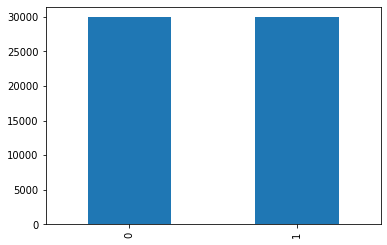

In [ ]:
df_ALL1['Interaction'].value_counts(sort=False).plot.bar()

ALL 3

In [ ]:
df_ALL3= load_data(ppi_paths['ALL3'], cols)
df_ALL3

,Prot 1,Prot 2,Interaction
0,Q9VGE2,Q9U3Z7,0
1,Q9VJJ0,Q9V5C6,1
2,Q24087,Q7KMG7,1
3,Q9XYN7,Q9V5C6,1
4,Q01842,P51023,1
...,...,...,...
47191,P23642,P39107,1
47192,P33203,Q12309,1
47193,Q12018,P32608,1
47194,P32361,P36016,1


In [ ]:
embeddings_dict= load_dict(embeddings_paths['ALL'])

In [ ]:
all3_embs_dict = embeddings_calc(df_ALL3)

### Load Data SC

In [ ]:
embeddings_dict = load_dict(embeddings_paths['SC'])

SC 1

In [ ]:
df_SC1 = load_data(ppi_paths['SC1'], cols)
sc1_embs_dict = embeddings_calc(df_SC1)

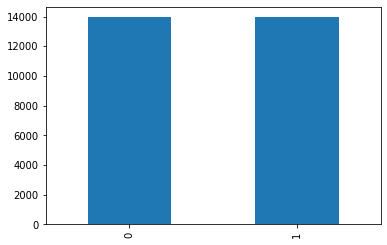

In [ ]:
df_SC1['Interaction'].value_counts(sort=False).plot.bar()

SC 3

In [ ]:
df_SC3= load_data(ppi_paths['SC3'], cols)
df_SC3

,Prot 1,Prot 2,Interaction
0,Q03435,P47169,0
1,P53168,Q08236,0
2,P14906,P80967,0
3,P35732,P39015,0
4,P32790,P40344,0
...,...,...,...
16899,P23642,P39107,1
16900,P33203,Q12309,1
16901,Q12018,P32608,1
16902,P32361,P36016,1


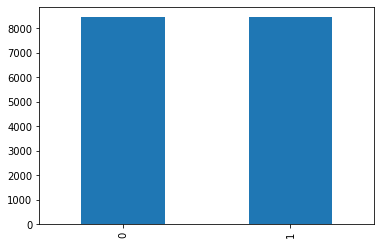

In [ ]:
df_SC3['Interaction'].value_counts(sort=False).plot.bar()

In [ ]:
embeddings_dict= load_dict(embeddings_paths['SC'])

In [ ]:
sc3_embs_dict = embeddings_calc(df_SC3)

### Load Data DM

In [ ]:
embeddings_dict = load_dict(embeddings_paths['DM'])

DM 1

In [ ]:
df_DM1 = load_data(ppi_paths['DM1'], cols)
dm1_embs_dict = embeddings_calc(df_DM1)

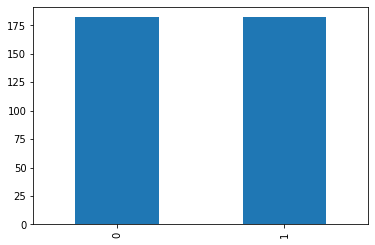

In [ ]:
df_DM1['Interaction'].value_counts(sort=False).plot.bar()

DM 3

In [ ]:
df_DM3= load_data(ppi_paths['DM3'], cols)
df_DM3

,Prot 1,Prot 2,Interaction
0,Q9VGE2,Q9U3Z7,0
1,Q9VJJ0,Q9V5C6,1
2,Q24087,Q7KMG7,1
3,Q9XYN7,Q9V5C6,1
4,Q01842,P51023,1
...,...,...,...
195,Q9XZJ4,Q9VDC6,0
196,Q94533,Q9VWN3,0
197,P83949,O97102,0
198,Q9VDC6,Q9V778,0


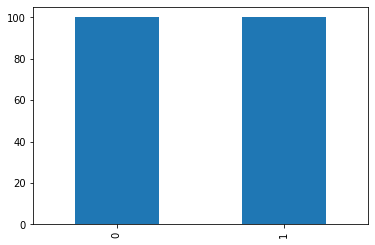

In [ ]:
df_DM3['Interaction'].value_counts(sort=False).plot.bar()

In [ ]:
embeddings_dict= load_dict(embeddings_paths['DM'])

In [ ]:
dm3_embs_dict = embeddings_calc(df_DM3)

### Load Data EC

In [ ]:
embeddings_dict = load_dict(embeddings_paths['EC'])

EC 1

In [ ]:
df_EC1 = load_data(ppi_paths['EC1'], cols)
ec1_embs_dict = embeddings_calc(df_EC1)

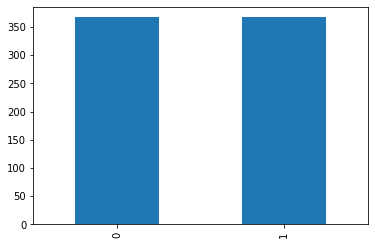

In [ ]:
df_EC1['Interaction'].value_counts(sort=False).plot.bar()

EC 3

In [ ]:
df_EC3= load_data(ppi_paths['EC3'], cols)
df_EC3

,Prot 1,Prot 2,Interaction
0,P07017,P0A964,1
1,P0ACE3,P0ACF8,1
2,P0ACJ8,P06136,0
3,P0A8F0,P23909,0
4,P39177,P0A6F5,1
...,...,...,...
415,P03018,P23367,1
416,P60723,P0A7M2,1
417,P11349,P0AF32,1
418,P0A7J7,P0A7L0,1


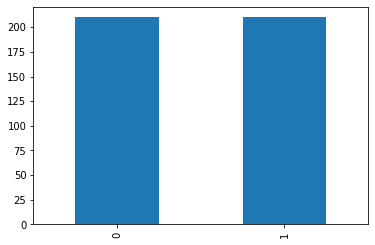

In [ ]:
df_EC3['Interaction'].value_counts(sort=False).plot.bar()

In [ ]:
embeddings_dict= load_dict(embeddings_paths['EC'])

In [ ]:
ec3_embs_dict = embeddings_calc(df_EC3)

### Load Data HS

In [ ]:
embeddings_dict = load_dict(embeddings_paths['HS'])

HS 1

In [ ]:
df_HS1 = load_data(ppi_paths['HS1'], cols)
hs1_embs_dict = embeddings_calc(df_HS1)

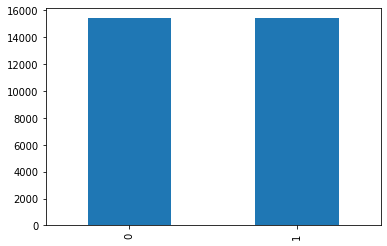

In [ ]:
df_HS1['Interaction'].value_counts(sort=False).plot.bar()

HS 3

In [ ]:
df_HS3= load_data(ppi_paths['HS3'], cols)
df_HS3

,Prot 1,Prot 2,Interaction
0,O14777,Q9Y2J4,1
1,Q99679,P22310,0
2,P08236,P23141,1
3,Q92793,Q9UHV2,1
4,P02768,P98164,1
...,...,...,...
29667,O60486,O75326,1
29668,Q96JZ2,P07332,1
29669,Q96SN8,Q14194,1
29670,Q13574,P21673,1


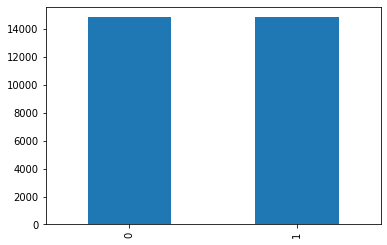

In [ ]:
df_HS3['Interaction'].value_counts(sort=False).plot.bar()

In [ ]:
embeddings_dict= load_dict(embeddings_paths['HS'])

In [ ]:
hs3_embs_dict = embeddings_calc(df_HS3)

# ALL Embeddings

## Random Forest Parameter Optimization

#### Baseline

In [ ]:
X = df_ALL1.drop(columns = 'Interaction').to_numpy()
y = df_ALL1['Interaction']

scores_forest = []

clf = RandomForestClassifier()
scores_forest.append(train_test_model(X, y, clf, 10, all1_embs_dict, 'hadamard', 'Hadamard'))
scores_forest_df = pd.DataFrame(scores_forest)
scores_forest_df

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.7321,1.0,0.7254,0.7441,0.7076,Hadamard


### GridSearch

In [ ]:
"""
The GridSeachCV is a very time-consuming model that in this case takes more than 4 hours. We only executed this cell once to know what the best parameters are and decided to include this
cell in quotes since there is no point in running it every time.

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grid = [
   {'n_estimators': [100, 200], 'max_depth': range(6, 14, 2), 'min_samples_split': range(2,11,4), 'max_features': ['auto', 'sqrt', 'log2']}
 ]

X_train, X_test, y_train, y_test = train_test_split([all1_embs_dict[x][0] for x in range(len(X))], y, test_size=0.3, random_state=0)
scores = ['precision', 'recall']
for score in scores:
  print("# Tuning hyper-parameters for %s" % score)
  clf = GridSearchCV(RandomForestClassifier(), param_grid, scoring='%s_macro' % score)
  clf.fit(X_train, y_train)
  print("Best parameters set found on development set:")
  print()
  print(clf.best_params_)
  print()
  print("Grid scores on development set:")
  print()
  means = clf.cv_results_['mean_test_score']
  stds = clf.cv_results_['std_test_score']
  for mean, std, params in zip(means, stds, clf.cv_results_['params']):
      print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))
  print()
  print("Detailed classification report:")
  print()
  print("The model is trained on the full development set.")
  print("The scores are computed on the full evaluation set.")
  print()
  y_true, y_pred = y_test, clf.predict(X_test)
  print(classification_report(y_true, y_pred))
  print()"""

'\nThe GridSeachCV is a very time-consuming model that in this case takes more than 4 hours. We only executed this cell once to know what the best parameters are and decided to include this\ncell in quotes since there is no point in running it every time.\n\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import classification_report\n\nparam_grid = [\n   {\'n_estimators\': [100, 200], \'max_depth\': range(6, 14, 2), \'min_samples_split\': range(2,11,4), \'max_features\': [\'auto\', \'sqrt\', \'log2\']}\n ]\n\nX_train, X_test, y_train, y_test = train_test_split([all1_embs_dict[x][0] for x in range(len(X))], y, test_size=0.3, random_state=0)\nscores = [\'precision\', \'recall\']\nfor score in scores:\n  print("# Tuning hyper-parameters for %s" % score)\n  clf = GridSearchCV(RandomForestClassifier(), param_grid, scoring=\'%s_macro\' % score)\n  clf.fit(X_train, y_train)\n  print("Best parameters set found on dev

## Random Forest

In [ ]:
X = df_ALL1.drop(columns = 'Interaction').to_numpy()
y = df_ALL1['Interaction']
scores_forest = []
models_all1 = {}

In [ ]:
for method in method_dict.keys():
    models_all1[method] = RandomForestClassifier(max_depth=12, max_features='log2', min_samples_split=10, n_estimators=200, random_state=0)
    scores_forest.append(train_test_model(X, y, models_all1[method], 10, all1_embs_dict, method, method))

In [ ]:
scores_forest_df = pd.DataFrame(scores_forest)
scores_forest_df.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.7277,0.8900,0.7319,0.7209,0.7433,hadamard
4,0.7219,0.8876,0.6946,0.7704,0.6324,max
5,0.7164,0.8833,0.7058,0.7332,0.6805,min
3,0.6652,0.9306,0.6223,0.7140,0.5515,concatenation
1,0.6612,0.8533,0.6273,0.6972,0.5702,mean
2,0.6612,0.8534,0.6273,0.6972,0.5702,addition


## Decision Tree

### Entropy Criterion


In [ ]:
scores_dt_entropy=[]
models_all1_dt_entropy = {}
for method in method_dict.keys():
    models_all1_dt_entropy[method] = DecisionTreeClassifier(random_state=0, criterion='entropy')
    scores_dt_entropy.append(train_test_model(X, y, models_all1_dt_entropy[method], 10, all1_embs_dict, method, method))

In [ ]:
scores_dt_entropy_df = pd.DataFrame(scores_dt_entropy)
scores_dt_entropy_df

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.6228,1.0,0.6356,0.6148,0.6578,hadamard
1,0.5648,1.0,0.5564,0.5674,0.5458,mean
2,0.5648,1.0,0.5564,0.5674,0.5458,addition
3,0.5636,1.0,0.5471,0.5687,0.5271,concatenation
4,0.5868,1.0,0.5990,0.5820,0.6170,max
5,0.5937,1.0,0.6006,0.5906,0.6110,min


### Gini Criterion

In [ ]:
scores_dt_gini=[]
models_all1_dt_gini = {}
for method in method_dict.keys():
    models_all1_dt_gini[method] = DecisionTreeClassifier(random_state=0, criterion='gini')
    scores_dt_gini.append(train_test_model(X, y, models_all1_dt_gini[method], 10, all1_embs_dict, method, method))

In [ ]:
scores_dt_gini_df = pd.DataFrame(scores_dt_gini)
scores_dt_gini_df

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.6129,1.0,0.6291,0.6039,0.6564,hadamard
1,0.5741,1.0,0.5793,0.5725,0.5862,mean
2,0.5741,1.0,0.5793,0.5725,0.5862,addition
3,0.5686,1.0,0.5698,0.5683,0.5712,concatenation
4,0.5925,1.0,0.6040,0.5875,0.6213,max
5,0.6020,1.0,0.6129,0.5967,0.6300,min


## Gaussian Naive Bayes

In [ ]:
scores_gnb = []

models_all1_gnb = {}

for method in method_dict.keys():
    models_all1_gnb[method] = GaussianNB()
    scores_gnb.append(train_test_model(X, y, models_all1_gnb[method], 10, all1_embs_dict, method, method))

In [ ]:
scores_gnb_df = pd.DataFrame(scores_gnb)
scores_gnb_df.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
4,0.6437,0.7160,0.6274,0.6575,0.5999,max
5,0.6430,0.7220,0.6109,0.6713,0.5605,min
0,0.6236,0.6973,0.5567,0.6772,0.4726,hadamard
1,0.6017,0.6779,0.5482,0.6334,0.4833,mean
2,0.6017,0.6779,0.5482,0.6334,0.4833,addition
3,0.5599,0.6073,0.4737,0.5893,0.3961,concatenation


## Multi-layer Perceptron classifier

In [ ]:
scores_mlp = []

models_all1_mlp = {}

for method in method_dict.keys():
    models_all1_mlp[method] = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
    scores_mlp.append(train_test_model(X, y, models_all1_mlp[method], 10, all1_embs_dict, method, method))

In [ ]:
scores_mlp_df = pd.DataFrame(scores_mlp)
scores_mlp_df.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.7032,0.9934,0.7093,0.6950,0.7243,hadamard
5,0.7003,0.9911,0.7138,0.6832,0.7473,min
4,0.6799,0.9902,0.7151,0.6444,0.8031,max
1,0.6766,0.9914,0.7024,0.6505,0.7634,mean
2,0.6732,0.9927,0.6911,0.6554,0.7309,addition
3,0.6691,0.9952,0.6663,0.6720,0.6608,concatenation


## Support Vector Machines

In [ ]:
scores_svc = []

models_all1_svc = {}

for method in method_dict.keys():
    models_all1_svc[method] = SVC()
    scores_svc.append(train_test_model(X, y, models_all1_svc[method], 10, all1_embs_dict, method, method))

In [ ]:
scores_svc_df = pd.DataFrame(scores_svc)
scores_svc_df.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.7259,0.8524,0.7397,0.7044,0.7787,hadamard
4,0.7125,0.8413,0.7333,0.6839,0.7904,max
5,0.7095,0.8413,0.7301,0.6818,0.7858,min
1,0.7045,0.8215,0.7324,0.6692,0.8088,mean
2,0.7045,0.8215,0.7324,0.6692,0.8088,addition
3,0.7010,0.8545,0.7145,0.6837,0.7483,concatenation


# ALL3

## Random Forest

In [ ]:
X = df_ALL3.drop(columns = 'Interaction').to_numpy()
y = df_ALL3['Interaction']

scores_forest_ALL3 = []
models_ALL3 = {}

for method in method_dict.keys():
    models_ALL3[method] = RandomForestClassifier(max_depth=12, max_features='log2', min_samples_split=10, n_estimators=200, random_state=0)
    scores_forest_ALL3.append(train_test_model(X, y, models_ALL3[method], 10, all3_embs_dict, method, method))

In [ ]:
scores_forest_df_ALL3 = pd.DataFrame(scores_forest_ALL3)
scores_forest_df_ALL3.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
4,0.7278,0.8969,0.7110,0.7575,0.6699,max
0,0.7254,0.9015,0.7301,0.7179,0.7428,hadamard
5,0.7140,0.8942,0.7021,0.7325,0.6742,min
3,0.6858,0.9435,0.6647,0.7126,0.6229,concatenation
2,0.6686,0.8650,0.6396,0.7010,0.5881,addition
1,0.6682,0.8648,0.6392,0.7005,0.5877,mean


## Multi-layer Perceptron classifier

In [ ]:
scores_mlp_ALL3 = []
models_ALL3_mlp = {}

for method in method_dict.keys():
    models_ALL3_mlp[method] =MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
    scores_mlp_ALL3.append(train_test_model(X, y, models_ALL3_mlp[method], 10, all3_embs_dict, method, method))

In [ ]:
scores_mlp_df_ALL3 = pd.DataFrame(scores_mlp_ALL3)
scores_mlp_df_ALL3.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.6994,0.9910,0.7190,0.6750,0.7691,hadamard
4,0.6985,0.9929,0.7067,0.6881,0.7263,max
2,0.6956,0.9855,0.7141,0.6730,0.7606,addition
3,0.6934,0.9960,0.7013,0.6837,0.7199,concatenation
5,0.6886,0.9851,0.7090,0.6653,0.7589,min
1,0.6845,0.9879,0.7064,0.6606,0.7589,mean


## Support Vector Machines

In [ ]:
scores_svc_ALL3 = []
models_ALL3_svc = {}

for method in method_dict.keys():
    models_ALL3_svc[method] = SVC()
    scores_svc_ALL3.append(train_test_model(X, y, models_ALL3_svc[method], 10, all3_embs_dict, method, method))

In [ ]:
scores_svc_df_ALL3 = pd.DataFrame(scores_svc_ALL3)
scores_svc_df_ALL3.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.7400,0.8482,0.7466,0.7282,0.7661,hadamard
5,0.7254,0.8304,0.7378,0.7060,0.7725,min
4,0.7248,0.8312,0.7382,0.7040,0.7758,max
1,0.7237,0.8082,0.7422,0.6957,0.7953,mean
2,0.7237,0.8082,0.7422,0.6957,0.7953,addition
3,0.7201,0.8445,0.7350,0.6979,0.7763,concatenation



# *Drosophila melanogaster*

## Random Forest DM1

In [ ]:
X = df_DM1.drop(columns = 'Interaction').to_numpy()
y = df_DM1['Interaction']
scores_forest_DM1 = []

In [ ]:
models_DM1 = {}

for method in method_dict.keys():
    models_DM1[method] = RandomForestClassifier(max_depth=12, max_features='log2', min_samples_split=10, n_estimators=200, random_state=0)
    scores_forest_DM1.append(train_test_model(X, y, models_DM1[method], 10, dm1_embs_dict, method, method))

In [ ]:
scores_forest_df_DM1 = pd.DataFrame(scores_forest_DM1)
scores_forest_df_DM1.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.9730,1.0000,0.9744,0.9500,1.0000,hadamard
4,0.9730,1.0000,0.9744,0.9500,1.0000,max
5,0.9730,0.9969,0.9744,0.9500,1.0000,min
1,0.9459,0.9969,0.9500,0.9048,1.0000,mean
2,0.9459,0.9969,0.9500,0.9048,1.0000,addition
3,0.9459,1.0000,0.9474,0.9474,0.9474,concatenation


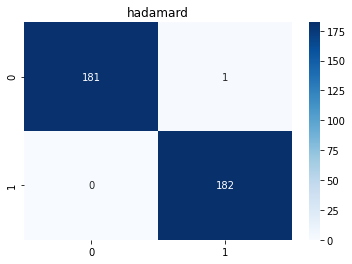

{'accuracy': 0.9973, 'f1': 0.9973, 'precision': 0.9945, 'recall': 1.0, 'method': 'hadamard'}


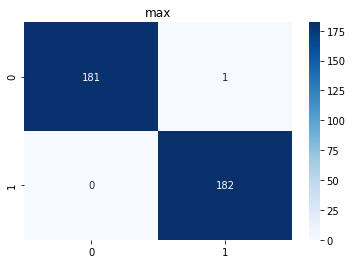

{'accuracy': 0.9973, 'f1': 0.9973, 'precision': 0.9945, 'recall': 1.0, 'method': 'max'}


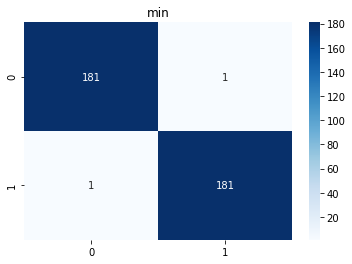

{'accuracy': 0.9945, 'f1': 0.9945, 'precision': 0.9945, 'recall': 0.9945, 'method': 'min'}


In [ ]:
plot_test_models(scores_forest_df_DM1, df_DM1, models_DM1, dm1_embs_dict)

### Testing on other species

Predicting EC

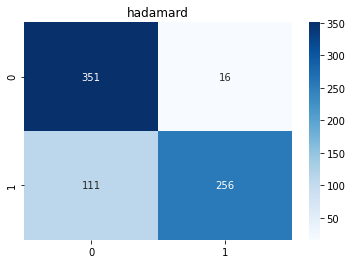

{'accuracy': 0.827, 'f1': 0.8013, 'precision': 0.9412, 'recall': 0.6975, 'method': 'hadamard'}


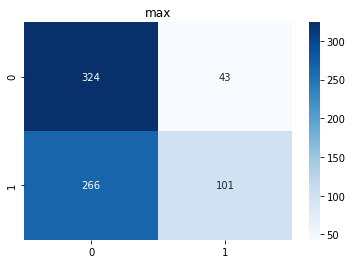

{'accuracy': 0.579, 'f1': 0.3953, 'precision': 0.7014, 'recall': 0.2752, 'method': 'max'}


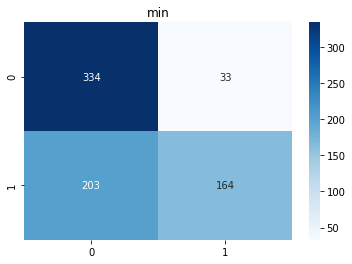

{'accuracy': 0.6785, 'f1': 0.5816, 'precision': 0.8325, 'recall': 0.4469, 'method': 'min'}


In [ ]:
plot_test_models(scores_forest_df_DM1, df_EC1, models_DM1, ec1_embs_dict)

Predicting HS

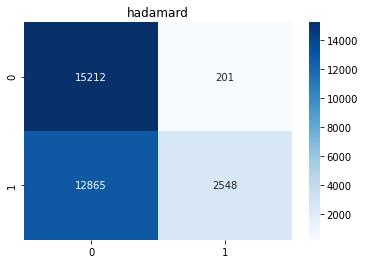

{'accuracy': 0.5761, 'f1': 0.2806, 'precision': 0.9269, 'recall': 0.1653, 'method': 'hadamard'}


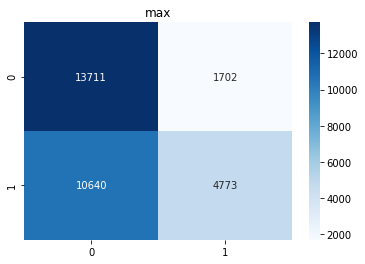

{'accuracy': 0.5996, 'f1': 0.4361, 'precision': 0.7371, 'recall': 0.3097, 'method': 'max'}


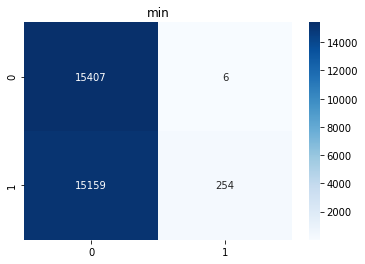

{'accuracy': 0.508, 'f1': 0.0324, 'precision': 0.9769, 'recall': 0.0165, 'method': 'min'}


In [ ]:
plot_test_models(scores_forest_df_DM1, df_HS1, models_DM1, hs1_embs_dict)

Predicting SC

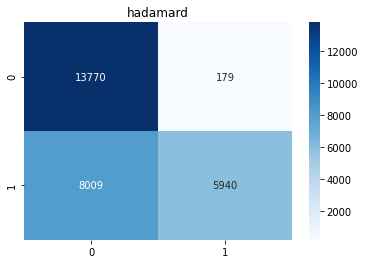

{'accuracy': 0.7065, 'f1': 0.592, 'precision': 0.9707, 'recall': 0.4258, 'method': 'hadamard'}


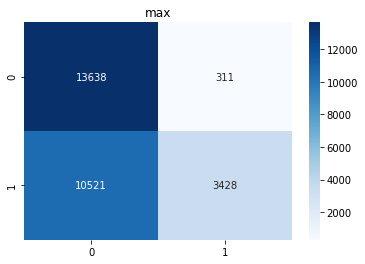

{'accuracy': 0.6117, 'f1': 0.3876, 'precision': 0.9168, 'recall': 0.2458, 'method': 'max'}


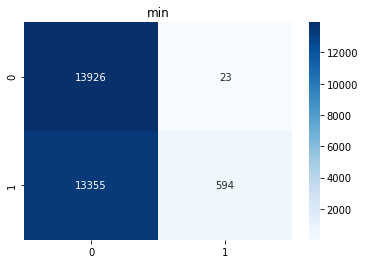

{'accuracy': 0.5205, 'f1': 0.0816, 'precision': 0.9627, 'recall': 0.0426, 'method': 'min'}


In [ ]:
plot_test_models(scores_forest_df_DM1, df_SC1, models_DM1, sc1_embs_dict)

## Random Forest DM3

In [ ]:
X = df_DM3.drop(columns = 'Interaction').to_numpy()
y = df_DM3['Interaction']

scores_forest_DM3 = []
models_DM3 = {}

for method in method_dict.keys():
    models_DM3[method] = RandomForestClassifier(max_depth=12, max_features='log2', min_samples_split=10, n_estimators=200, random_state=0)
    scores_forest_DM3.append(train_test_model(X, y, models_DM3[method], 10, dm3_embs_dict, method, method))

In [ ]:
scores_forest_df_DM3 = pd.DataFrame(scores_forest_DM3)
scores_forest_df_DM3.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.95,1.0,0.9524,0.9091,1.0,hadamard
4,0.85,1.0,0.8421,0.8889,0.8,max
5,0.85,1.0,0.8421,0.8889,0.8,min
1,0.75,1.0,0.7368,0.7778,0.7,mean
2,0.75,1.0,0.7368,0.7778,0.7,addition
3,0.70,1.0,0.7000,0.7000,0.7,concatenation


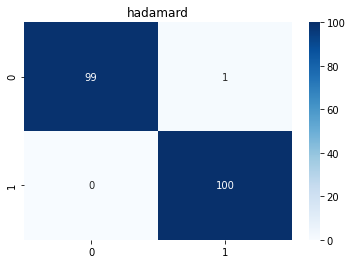

{'accuracy': 0.995, 'f1': 0.995, 'precision': 0.9901, 'recall': 1.0, 'method': 'hadamard'}


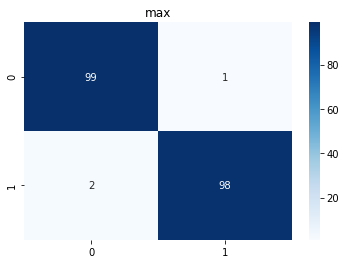

{'accuracy': 0.985, 'f1': 0.9849, 'precision': 0.9899, 'recall': 0.98, 'method': 'max'}


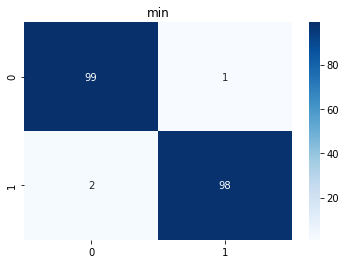

{'accuracy': 0.985, 'f1': 0.9849, 'precision': 0.9899, 'recall': 0.98, 'method': 'min'}


In [ ]:
plot_test_models(scores_forest_df_DM3, df_DM3, models_DM3, dm3_embs_dict)

### Testing on other species

Predicting EC

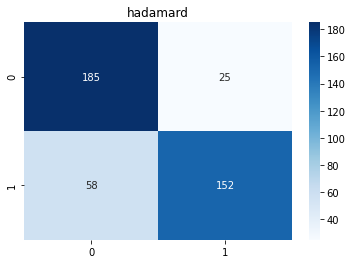

{'accuracy': 0.8024, 'f1': 0.7855, 'precision': 0.8588, 'recall': 0.7238, 'method': 'hadamard'}


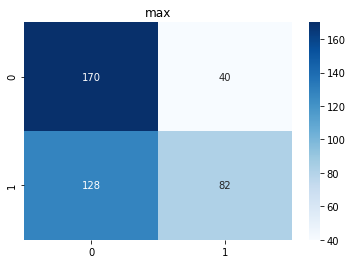

{'accuracy': 0.6, 'f1': 0.494, 'precision': 0.6721, 'recall': 0.3905, 'method': 'max'}


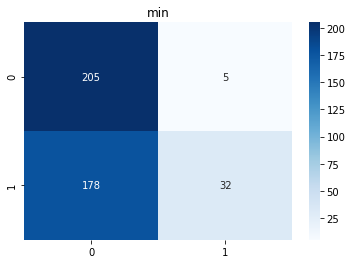

{'accuracy': 0.5643, 'f1': 0.2591, 'precision': 0.8649, 'recall': 0.1524, 'method': 'min'}


In [ ]:
plot_test_models(scores_forest_df_DM3, df_EC3, models_DM3, ec3_embs_dict)

Predicting HS

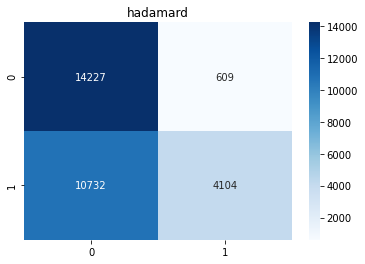

{'accuracy': 0.6178, 'f1': 0.4199, 'precision': 0.8708, 'recall': 0.2766, 'method': 'hadamard'}


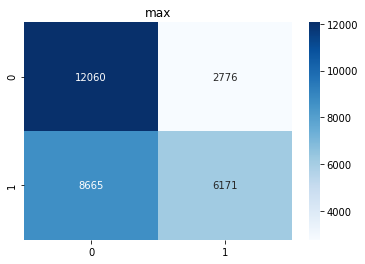

{'accuracy': 0.6144, 'f1': 0.5189, 'precision': 0.6897, 'recall': 0.4159, 'method': 'max'}


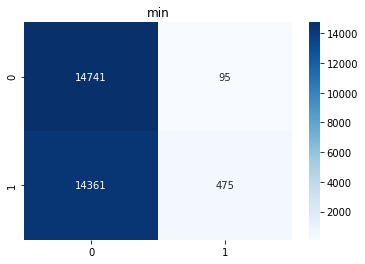

{'accuracy': 0.5128, 'f1': 0.0617, 'precision': 0.8333, 'recall': 0.032, 'method': 'min'}


In [ ]:
plot_test_models(scores_forest_df_DM3, df_HS3, models_DM3, hs3_embs_dict)

Predicting SC

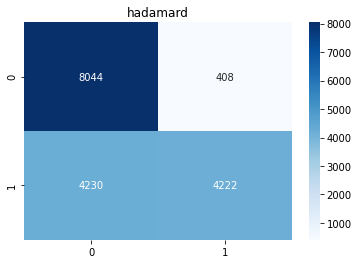

{'accuracy': 0.7256, 'f1': 0.6455, 'precision': 0.9119, 'recall': 0.4995, 'method': 'hadamard'}


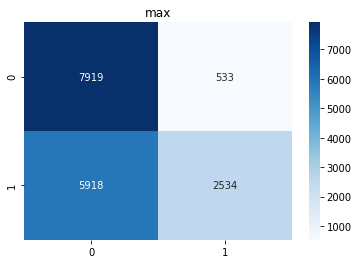

{'accuracy': 0.6184, 'f1': 0.44, 'precision': 0.8262, 'recall': 0.2998, 'method': 'max'}


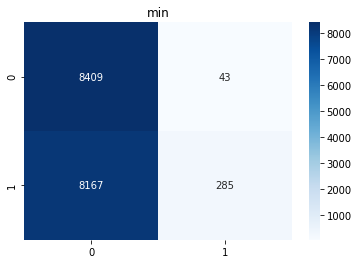

{'accuracy': 0.5143, 'f1': 0.0649, 'precision': 0.8689, 'recall': 0.0337, 'method': 'min'}


In [ ]:
plot_test_models(scores_forest_df_DM3, df_SC3, models_DM3, sc3_embs_dict)

## Multi-layer Perceptron classifier



In [ ]:
scores_mlp_DM1 = []
models_DM1_mlp = {}

for method in method_dict.keys():
    models_DM1_mlp[method] = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
    scores_mlp_DM1.append(train_test_model(X, y, models_DM1_mlp[method], 10, dm1_embs_dict, method, method))

In [ ]:
scores_mlp_df_DM1 = pd.DataFrame(scores_mlp_DM1)
scores_mlp_df_DM1.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
4,0.60,1.0,0.5000,0.6667,0.4,max
0,0.50,1.0,0.4444,0.5000,0.4,hadamard
1,0.50,1.0,0.4444,0.5000,0.4,mean
2,0.50,1.0,0.4444,0.5000,0.4,addition
5,0.50,1.0,0.4444,0.5000,0.4,min
3,0.45,1.0,0.4211,0.4444,0.4,concatenation


## Support Vector Machines

In [ ]:
scores_svc_DM1 = []
models_DM1_svc = {}

for method in method_dict.keys():
    models_DM1_svc[method] = SVC()
    scores_svc_DM1.append(train_test_model(X, y, models_DM1_svc[method], 10, dm1_embs_dict, method, method))

In [ ]:
scores_svc_df_DM1 = pd.DataFrame(scores_svc_DM1)
scores_svc_df_DM1.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
5,0.60,0.6722,0.6000,0.6000,0.6,min
1,0.55,0.6278,0.5263,0.5556,0.5,mean
2,0.55,0.6278,0.5263,0.5556,0.5,addition
4,0.55,0.6944,0.5263,0.5556,0.5,max
0,0.50,0.7500,0.5000,0.5000,0.5,hadamard
3,0.50,0.7278,0.4444,0.5000,0.4,concatenation


# *Escherichia coli*

## Random Forest EC1

In [ ]:
X = df_EC1.drop(columns = 'Interaction').to_numpy()
y = df_EC1['Interaction']
scores_forest_EC1 = []

In [ ]:
models_EC1 = {}
scores_forest_EC1 = []
for method in method_dict.keys():
    models_EC1[method] = RandomForestClassifier(max_depth=12, max_features='log2', min_samples_split=10, n_estimators=200, random_state=0)
    scores_forest_EC1.append(train_test_model(X, y, models_EC1[method], 10, ec1_embs_dict, method, method))

In [ ]:
scores_forest_df_EC1 = pd.DataFrame(scores_forest_EC1)
scores_forest_df_EC1.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.8919,0.9970,0.8857,0.9394,0.8378,hadamard
1,0.8784,0.9864,0.8696,0.9375,0.8108,mean
2,0.8784,0.9864,0.8696,0.9375,0.8108,addition
5,0.8514,0.9939,0.8358,0.9333,0.7568,min
3,0.8108,0.9985,0.7742,0.9600,0.6486,concatenation
4,0.8108,0.9924,0.7941,0.8710,0.7297,max


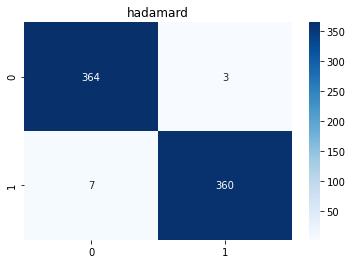

{'accuracy': 0.9864, 'f1': 0.9863, 'precision': 0.9917, 'recall': 0.9809, 'method': 'hadamard'}


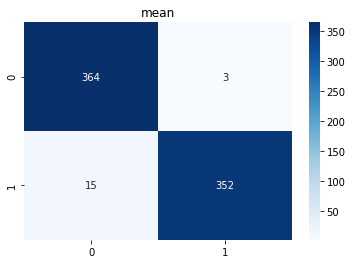

{'accuracy': 0.9755, 'f1': 0.9751, 'precision': 0.9915, 'recall': 0.9591, 'method': 'mean'}


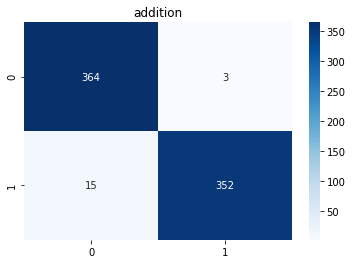

{'accuracy': 0.9755, 'f1': 0.9751, 'precision': 0.9915, 'recall': 0.9591, 'method': 'addition'}


In [ ]:
plot_test_models(scores_forest_df_EC1, df_EC1, models_EC1, ec1_embs_dict)

### Testing on other species

Testing DM

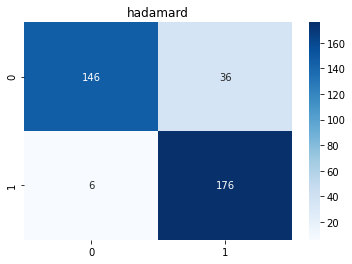

{'accuracy': 0.8846, 'f1': 0.8934, 'precision': 0.8302, 'recall': 0.967, 'method': 'hadamard'}


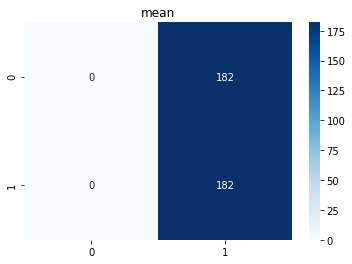

{'accuracy': 0.5, 'f1': 0.6667, 'precision': 0.5, 'recall': 1.0, 'method': 'mean'}


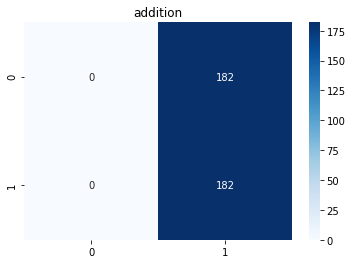

{'accuracy': 0.5, 'f1': 0.6667, 'precision': 0.5, 'recall': 1.0, 'method': 'addition'}


In [ ]:
plot_test_models(scores_forest_df_EC1, df_DM1, models_EC1, dm1_embs_dict)

Testing HS

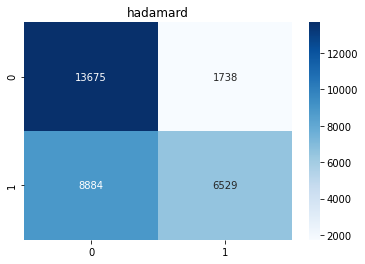

{'accuracy': 0.6554, 'f1': 0.5514, 'precision': 0.7898, 'recall': 0.4236, 'method': 'hadamard'}


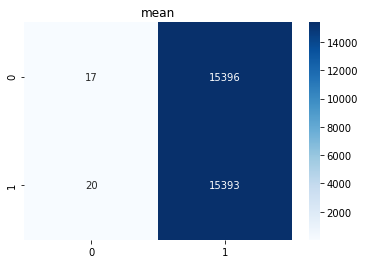

{'accuracy': 0.4999, 'f1': 0.6663, 'precision': 0.5, 'recall': 0.9987, 'method': 'mean'}


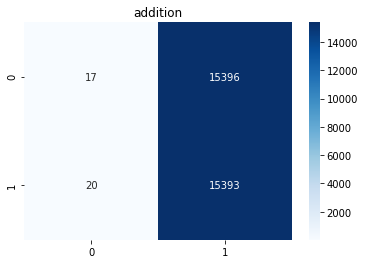

{'accuracy': 0.4999, 'f1': 0.6663, 'precision': 0.5, 'recall': 0.9987, 'method': 'addition'}


In [ ]:
plot_test_models(scores_forest_df_EC1, df_HS1, models_EC1, hs1_embs_dict)

Testing SC

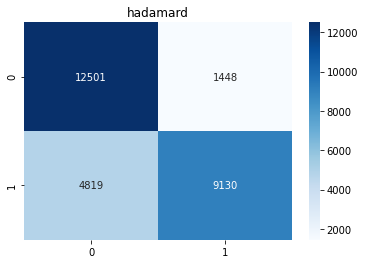

{'accuracy': 0.7754, 'f1': 0.7445, 'precision': 0.8631, 'recall': 0.6545, 'method': 'hadamard'}


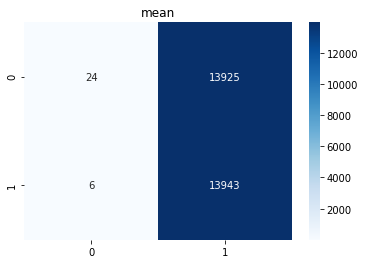

{'accuracy': 0.5006, 'f1': 0.6669, 'precision': 0.5003, 'recall': 0.9996, 'method': 'mean'}


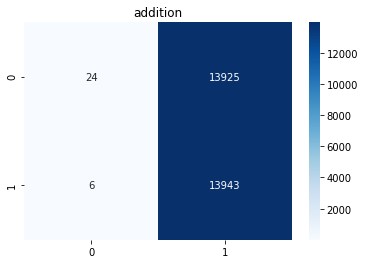

{'accuracy': 0.5006, 'f1': 0.6669, 'precision': 0.5003, 'recall': 0.9996, 'method': 'addition'}


In [ ]:
plot_test_models(scores_forest_df_EC1, df_SC1, models_EC1, sc1_embs_dict)

## Random Forest EC3

In [ ]:
X = df_EC3.drop(columns = 'Interaction').to_numpy()
y = df_EC3['Interaction']

scores_forest_EC3 = []
models_EC3 = {}

for method in method_dict.keys():
    models_EC3[method] = RandomForestClassifier(max_depth=12, max_features='log2', min_samples_split=10, n_estimators=200, random_state=0)
    scores_forest_EC3.append(train_test_model(X, y, models_EC3[method], 10, ec3_embs_dict, method, method))

In [ ]:
scores_forest_df_EC3 = pd.DataFrame(scores_forest_EC3)
scores_forest_df_EC3.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
4,0.8095,0.9894,0.7647,1.0000,0.6190,max
0,0.7619,1.0000,0.7059,0.9231,0.5714,hadamard
3,0.7619,0.9974,0.7222,0.8667,0.6190,concatenation
1,0.7381,0.9841,0.6857,0.8571,0.5714,mean
2,0.7381,0.9841,0.6857,0.8571,0.5714,addition
5,0.7143,0.9921,0.6250,0.9091,0.4762,min


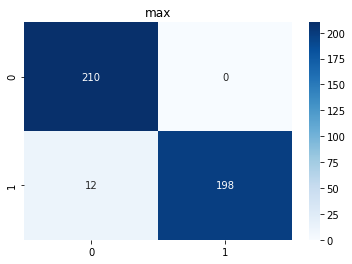

{'accuracy': 0.9714, 'f1': 0.9706, 'precision': 1.0, 'recall': 0.9429, 'method': 'max'}


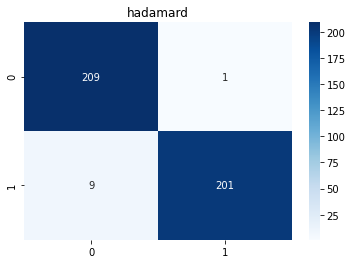

{'accuracy': 0.9762, 'f1': 0.9757, 'precision': 0.995, 'recall': 0.9571, 'method': 'hadamard'}


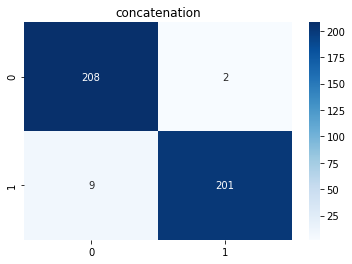

{'accuracy': 0.9738, 'f1': 0.9734, 'precision': 0.9901, 'recall': 0.9571, 'method': 'concatenation'}


In [ ]:
plot_test_models(scores_forest_df_EC3, df_EC3, models_EC3, ec3_embs_dict)

### Testing on other species

Testing DM

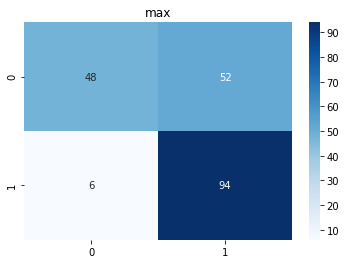

{'accuracy': 0.71, 'f1': 0.7642, 'precision': 0.6438, 'recall': 0.94, 'method': 'max'}


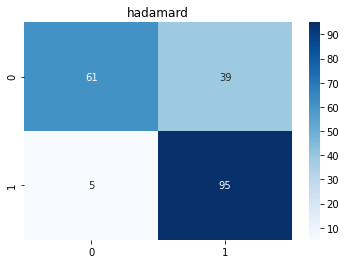

{'accuracy': 0.78, 'f1': 0.812, 'precision': 0.709, 'recall': 0.95, 'method': 'hadamard'}


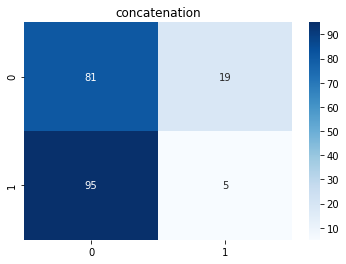

{'accuracy': 0.43, 'f1': 0.0806, 'precision': 0.2083, 'recall': 0.05, 'method': 'concatenation'}


In [ ]:
plot_test_models(scores_forest_df_EC3, df_DM3, models_EC3, dm3_embs_dict)

Testing HS

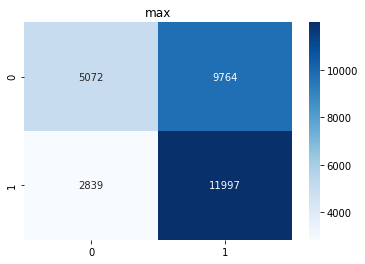

{'accuracy': 0.5753, 'f1': 0.6556, 'precision': 0.5513, 'recall': 0.8086, 'method': 'max'}


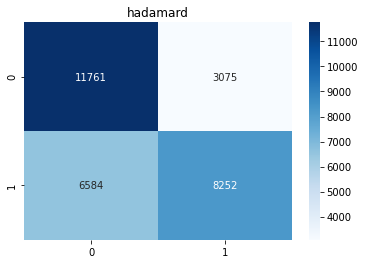

{'accuracy': 0.6745, 'f1': 0.6308, 'precision': 0.7285, 'recall': 0.5562, 'method': 'hadamard'}


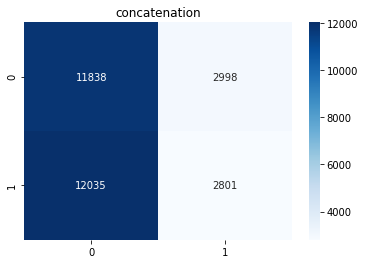

{'accuracy': 0.4934, 'f1': 0.2715, 'precision': 0.483, 'recall': 0.1888, 'method': 'concatenation'}


In [ ]:
plot_test_models(scores_forest_df_EC3, df_HS3, models_EC3, hs3_embs_dict)

Testing SC

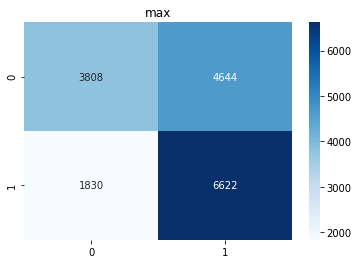

{'accuracy': 0.617, 'f1': 0.6717, 'precision': 0.5878, 'recall': 0.7835, 'method': 'max'}


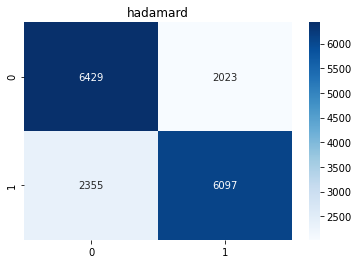

{'accuracy': 0.741, 'f1': 0.7358, 'precision': 0.7509, 'recall': 0.7214, 'method': 'hadamard'}


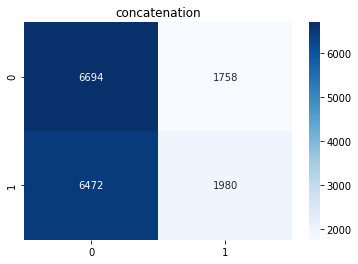

{'accuracy': 0.5131, 'f1': 0.3249, 'precision': 0.5297, 'recall': 0.2343, 'method': 'concatenation'}


In [ ]:
plot_test_models(scores_forest_df_EC3, df_SC3, models_EC3, sc3_embs_dict)

## Multi-layer Perceptron classifier




In [ ]:
scores_mlp_EC1 = []
models_EC1_mlp = {}

for method in method_dict.keys():
    models_EC1_mlp[method] = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
    scores_mlp_EC1.append(train_test_model(X, y, models_EC1_mlp[method], 10, ec1_embs_dict, method, method))

In [ ]:
scores_mlp_df_EC1 = pd.DataFrame(scores_mlp_EC1)
scores_mlp_df_EC1.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
1,0.60,1.0,0.5556,0.6250,0.5,mean
2,0.55,1.0,0.5263,0.5556,0.5,addition
4,0.55,1.0,0.5714,0.5455,0.6,max
5,0.45,1.0,0.3529,0.4286,0.3,min
0,0.40,1.0,0.4545,0.4167,0.5,hadamard
3,0.30,1.0,0.3636,0.3333,0.4,concatenation


## Support Vector Machines

In [ ]:
scores_svc_EC1 = []
models_EC1_svc = {}

for method in method_dict.keys():
    models_EC1_svc[method] = SVC()
    scores_svc_EC1.append(train_test_model(X, y, models_EC1_svc[method], 10, ec1_embs_dict, method, method))

In [ ]:
scores_svc_df_EC1 = pd.DataFrame(scores_svc_EC1)
scores_svc_df_EC1.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
4,0.60,0.7500,0.5556,0.6250,0.5,max
0,0.55,0.7889,0.6087,0.5385,0.7,hadamard
1,0.55,0.7222,0.4706,0.5714,0.4,mean
2,0.55,0.7222,0.4706,0.5714,0.4,addition
5,0.55,0.7500,0.5263,0.5556,0.5,min
3,0.45,0.7611,0.3529,0.4286,0.3,concatenation


# *Homo sapiens* 

## Random Forest HS1

In [ ]:
X = df_HS1.drop(columns = 'Interaction').to_numpy()
y = df_HS1['Interaction']
scores_forest_HS1 = []

In [ ]:
models_HS1 = {}

for method in method_dict.keys():
    models_HS1[method] = RandomForestClassifier(max_depth=12, max_features='log2', min_samples_split=10, n_estimators=200, random_state=0)
    scores_forest_HS1.append(train_test_model(X, y, models_HS1[method], 10, hs1_embs_dict, method, method))

In [ ]:
scores_forest_df_HS1 = pd.DataFrame(scores_forest_HS1)
scores_forest_df_HS1.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.7473,0.9163,0.7428,0.7560,0.7300,hadamard
4,0.7415,0.9206,0.7262,0.7715,0.6859,max
5,0.7363,0.9211,0.7221,0.7630,0.6853,min
3,0.7149,0.9502,0.7147,0.7149,0.7145,concatenation
1,0.7113,0.9015,0.6890,0.7464,0.6398,mean
2,0.7107,0.9016,0.6881,0.7460,0.6385,addition


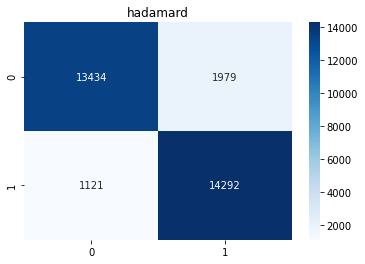

{'accuracy': 0.8994, 'f1': 0.9022, 'precision': 0.8784, 'recall': 0.9273, 'method': 'hadamard'}


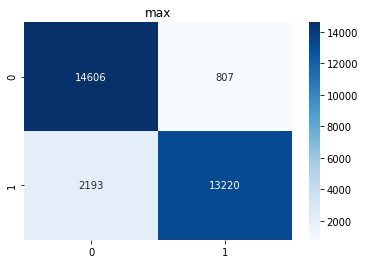

{'accuracy': 0.9027, 'f1': 0.8981, 'precision': 0.9425, 'recall': 0.8577, 'method': 'max'}


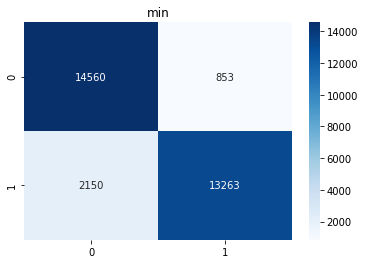

{'accuracy': 0.9026, 'f1': 0.8983, 'precision': 0.9396, 'recall': 0.8605, 'method': 'min'}


In [ ]:
plot_test_models(scores_forest_df_HS1, df_HS1, models_HS1, hs1_embs_dict)

### Testing on other species

Testing EC

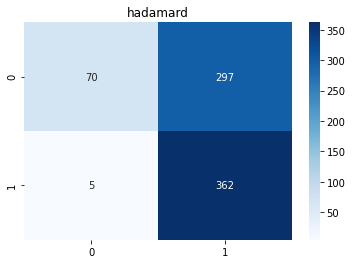

{'accuracy': 0.5886, 'f1': 0.7057, 'precision': 0.5493, 'recall': 0.9864, 'method': 'hadamard'}


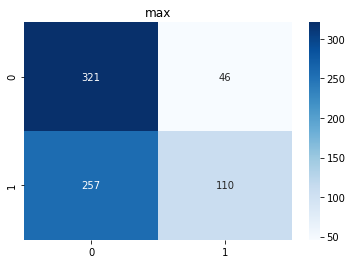

{'accuracy': 0.5872, 'f1': 0.4207, 'precision': 0.7051, 'recall': 0.2997, 'method': 'max'}


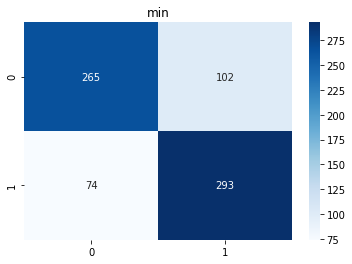

{'accuracy': 0.7602, 'f1': 0.769, 'precision': 0.7418, 'recall': 0.7984, 'method': 'min'}


In [ ]:
plot_test_models(scores_forest_df_HS1, df_EC1, models_HS1, ec1_embs_dict)

Testing DM

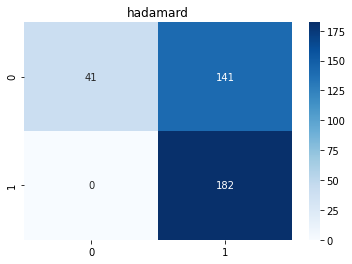

{'accuracy': 0.6126, 'f1': 0.7208, 'precision': 0.5635, 'recall': 1.0, 'method': 'hadamard'}


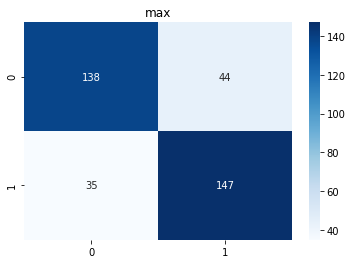

{'accuracy': 0.783, 'f1': 0.7882, 'precision': 0.7696, 'recall': 0.8077, 'method': 'max'}


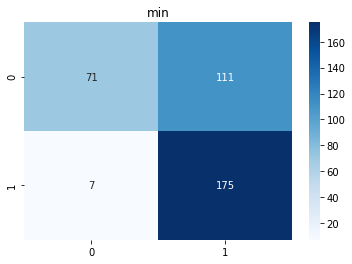

{'accuracy': 0.6758, 'f1': 0.7479, 'precision': 0.6119, 'recall': 0.9615, 'method': 'min'}


In [ ]:
plot_test_models(scores_forest_df_HS1, df_DM1, models_HS1, dm1_embs_dict)

Testing SC

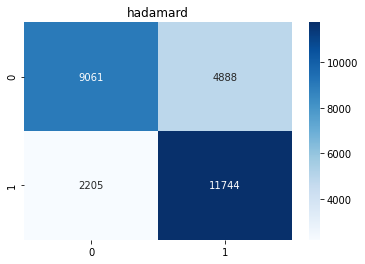

{'accuracy': 0.7458, 'f1': 0.7681, 'precision': 0.7061, 'recall': 0.8419, 'method': 'hadamard'}


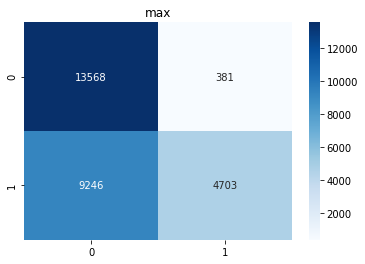

{'accuracy': 0.6549, 'f1': 0.4942, 'precision': 0.9251, 'recall': 0.3372, 'method': 'max'}


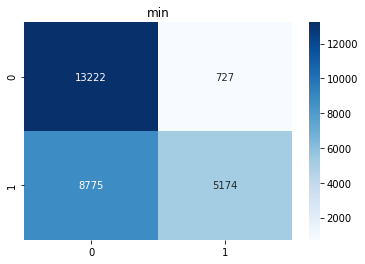

{'accuracy': 0.6594, 'f1': 0.5213, 'precision': 0.8768, 'recall': 0.3709, 'method': 'min'}


In [ ]:
plot_test_models(scores_forest_df_HS1, df_SC1, models_HS1, sc1_embs_dict)

## Random Forest HS3

In [ ]:
X = df_HS3.drop(columns = 'Interaction').to_numpy()
y = df_HS3['Interaction']

scores_forest_HS3 = []
models_HS3 = {}

for method in method_dict.keys():
    models_HS3[method] = RandomForestClassifier(max_depth=12, max_features='log2', min_samples_split=10, n_estimators=200, random_state=0)
    scores_forest_HS3.append(train_test_model(X, y, models_HS3[method], 10, hs3_embs_dict, method, method))

In [ ]:
scores_forest_df_HS3 = pd.DataFrame(scores_forest_HS3)
scores_forest_df_HS3.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.7426,0.9193,0.7378,0.7517,0.7244,hadamard
5,0.7321,0.9255,0.7186,0.7569,0.6840,min
4,0.7271,0.9237,0.7124,0.7530,0.6759,max
3,0.7177,0.9513,0.7188,0.7159,0.7217,concatenation
1,0.7052,0.9078,0.6803,0.7430,0.6274,mean
2,0.7052,0.9078,0.6803,0.7430,0.6274,addition


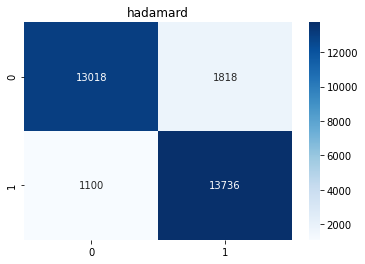

{'accuracy': 0.9017, 'f1': 0.904, 'precision': 0.8831, 'recall': 0.9259, 'method': 'hadamard'}


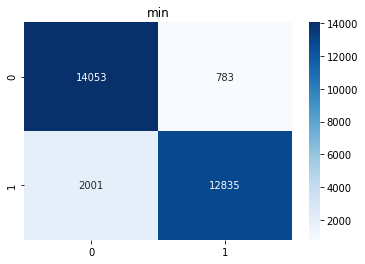

{'accuracy': 0.9062, 'f1': 0.9022, 'precision': 0.9425, 'recall': 0.8651, 'method': 'min'}


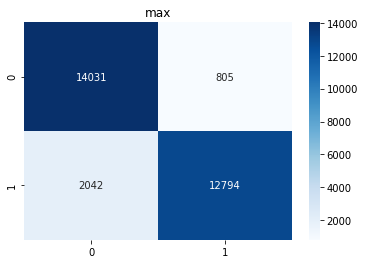

{'accuracy': 0.9041, 'f1': 0.8999, 'precision': 0.9408, 'recall': 0.8624, 'method': 'max'}


In [ ]:
plot_test_models(scores_forest_df_HS3, df_HS3, models_HS3, hs3_embs_dict)

### Testing on other species

Testing EC

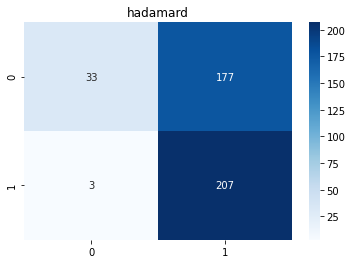

{'accuracy': 0.5714, 'f1': 0.697, 'precision': 0.5391, 'recall': 0.9857, 'method': 'hadamard'}


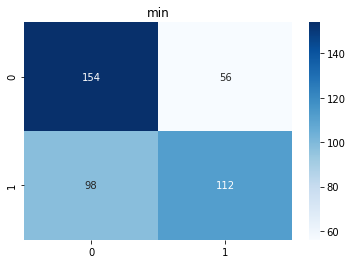

{'accuracy': 0.6333, 'f1': 0.5926, 'precision': 0.6667, 'recall': 0.5333, 'method': 'min'}


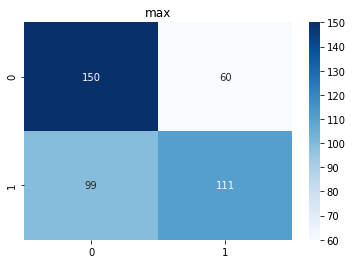

{'accuracy': 0.6214, 'f1': 0.5827, 'precision': 0.6491, 'recall': 0.5286, 'method': 'max'}


In [ ]:
plot_test_models(scores_forest_df_HS3, df_EC3, models_HS3, ec3_embs_dict)

Testing DM

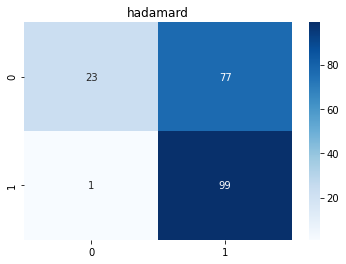

{'accuracy': 0.61, 'f1': 0.7174, 'precision': 0.5625, 'recall': 0.99, 'method': 'hadamard'}


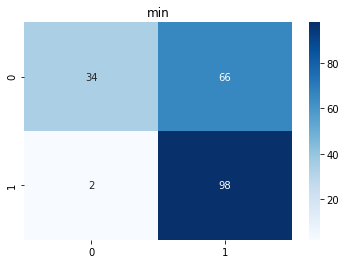

{'accuracy': 0.66, 'f1': 0.7424, 'precision': 0.5976, 'recall': 0.98, 'method': 'min'}


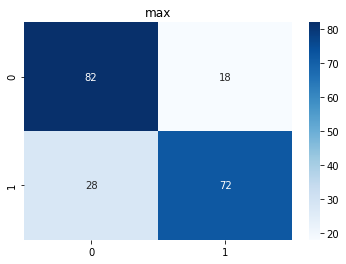

{'accuracy': 0.77, 'f1': 0.7579, 'precision': 0.8, 'recall': 0.72, 'method': 'max'}


In [ ]:
plot_test_models(scores_forest_df_HS3, df_DM3, models_HS3, dm3_embs_dict)

Testing SC

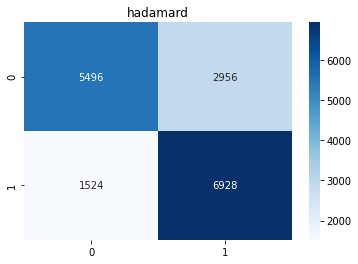

{'accuracy': 0.735, 'f1': 0.7557, 'precision': 0.7009, 'recall': 0.8197, 'method': 'hadamard'}


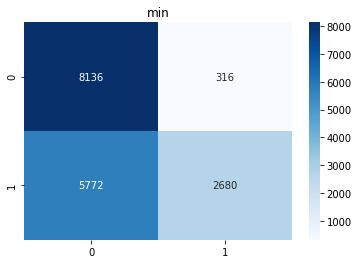

{'accuracy': 0.6398, 'f1': 0.4682, 'precision': 0.8945, 'recall': 0.3171, 'method': 'min'}


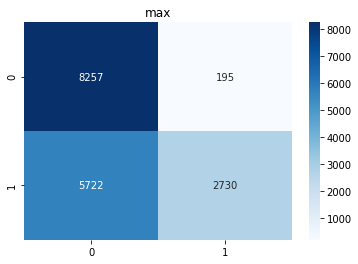

{'accuracy': 0.65, 'f1': 0.4799, 'precision': 0.9333, 'recall': 0.323, 'method': 'max'}


In [ ]:
plot_test_models(scores_forest_df_HS3, df_SC3, models_HS3, sc3_embs_dict)

## Multi-layer Perceptron classifier


In [ ]:
scores_mlp_HS1 = []
models_HS1_mlp = {}

for method in method_dict.keys():
    models_HS1_mlp[method] = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
    scores_mlp_HS1.append(train_test_model(X, y, models_HS1_mlp[method], 10, hs1_embs_dict, method, method))

In [ ]:
scores_mlp_df_HS1 = pd.DataFrame(scores_mlp_HS1)
scores_mlp_df_HS1.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
5,0.5121,0.9994,0.5151,0.5120,0.5182,min
1,0.5101,0.9735,0.5163,0.5099,0.5229,mean
4,0.5081,0.9915,0.4699,0.5094,0.4360,max
2,0.4997,0.9999,0.4892,0.4996,0.4791,addition
0,0.4987,0.9993,0.4768,0.4985,0.4569,hadamard
3,0.4956,1.0000,0.4927,0.4956,0.4899,concatenation


## Support Vector Machines

In [ ]:
scores_svc_HS1 = []
models_HS1_svc = {}

for method in method_dict.keys():
    models_HS1_svc[method] = SVC()
    scores_svc_HS1.append(train_test_model(X, y, models_HS1_svc[method], 10, hs1_embs_dict, method, method))

In [ ]:
scores_svc_df_HS1 = pd.DataFrame(scores_svc_HS1)
scores_svc_df_HS1.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
3,0.5024,0.6999,0.4870,0.5025,0.4724,concatenation
1,0.5003,0.6358,0.4705,0.5004,0.4441,mean
2,0.5003,0.6358,0.4705,0.5004,0.4441,addition
0,0.4960,0.7223,0.4467,0.4951,0.4070,hadamard
4,0.4933,0.6692,0.4450,0.4918,0.4063,max
5,0.4926,0.6710,0.4372,0.4908,0.3942,min


# *Saccharomyces cerevisiae*


## Random Forest SC1

In [ ]:
X = df_SC1.drop(columns = 'Interaction').to_numpy()
y = df_SC1['Interaction']
scores_forest_SC1 = []

In [ ]:
models_SC1 = {}

for method in method_dict.keys():
    models_SC1[method] = RandomForestClassifier(max_depth=12, max_features='log2', min_samples_split=10, n_estimators=200, random_state=0)
    scores_forest_SC1.append(train_test_model(X, y, models_SC1[method], 10, sc1_embs_dict, method, method))

In [ ]:
scores_forest_df_SC1 = pd.DataFrame(scores_forest_SC1)
scores_forest_df_SC1.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.8473,0.9273,0.8335,0.9166,0.7642,hadamard
5,0.8412,0.9182,0.8251,0.9183,0.7491,min
4,0.8387,0.9159,0.8237,0.9084,0.7534,max
3,0.8301,0.9519,0.8166,0.8873,0.7563,concatenation
1,0.8054,0.8932,0.7817,0.8901,0.6968,mean
2,0.8054,0.8932,0.7817,0.8901,0.6968,addition


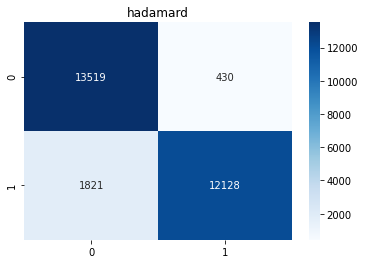

{'accuracy': 0.9193, 'f1': 0.9151, 'precision': 0.9658, 'recall': 0.8695, 'method': 'hadamard'}


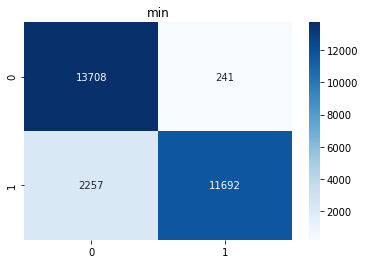

{'accuracy': 0.9105, 'f1': 0.9035, 'precision': 0.9798, 'recall': 0.8382, 'method': 'min'}


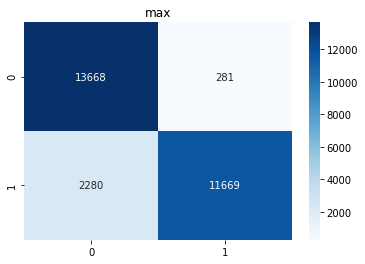

{'accuracy': 0.9082, 'f1': 0.9011, 'precision': 0.9765, 'recall': 0.8365, 'method': 'max'}


In [ ]:
plot_test_models(scores_forest_df_SC1, df_SC1, models_SC1, sc1_embs_dict)

### Testing on other species

Testing DM

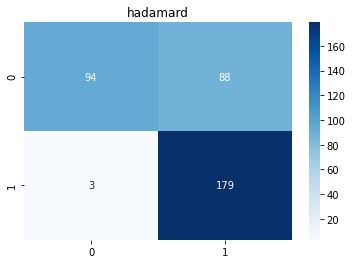

{'accuracy': 0.75, 'f1': 0.7973, 'precision': 0.6704, 'recall': 0.9835, 'method': 'hadamard'}


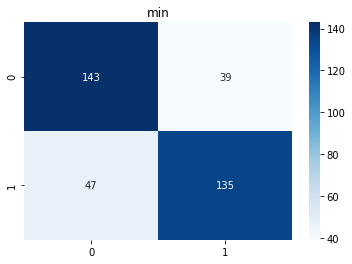

{'accuracy': 0.7637, 'f1': 0.7584, 'precision': 0.7759, 'recall': 0.7418, 'method': 'min'}


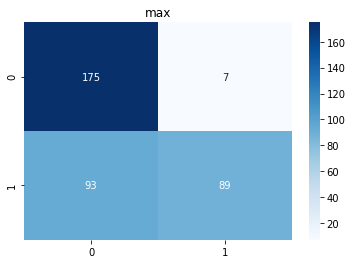

{'accuracy': 0.7253, 'f1': 0.6403, 'precision': 0.9271, 'recall': 0.489, 'method': 'max'}


In [ ]:
plot_test_models(scores_forest_df_SC1, df_DM1, models_SC1, dm1_embs_dict)

Testing EC

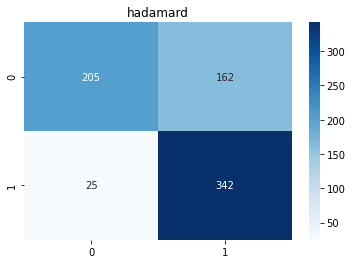

{'accuracy': 0.7452, 'f1': 0.7853, 'precision': 0.6786, 'recall': 0.9319, 'method': 'hadamard'}


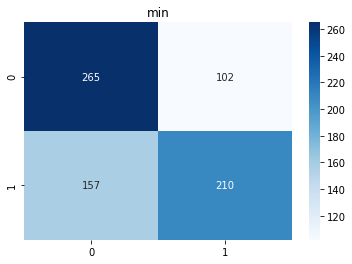

{'accuracy': 0.6471, 'f1': 0.6186, 'precision': 0.6731, 'recall': 0.5722, 'method': 'min'}


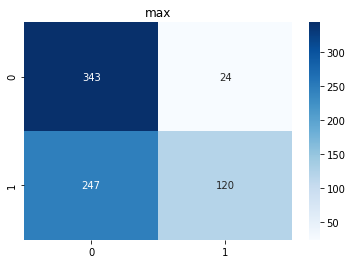

{'accuracy': 0.6308, 'f1': 0.4697, 'precision': 0.8333, 'recall': 0.327, 'method': 'max'}


In [ ]:
plot_test_models(scores_forest_df_SC1, df_EC1, models_SC1, ec1_embs_dict)

Testing HS

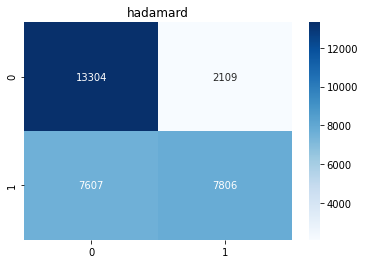

{'accuracy': 0.6848, 'f1': 0.6164, 'precision': 0.7873, 'recall': 0.5065, 'method': 'hadamard'}


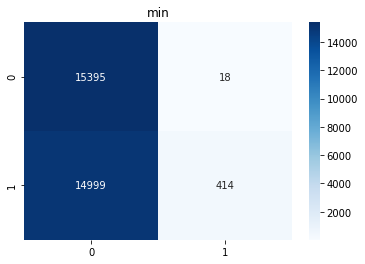

{'accuracy': 0.5128, 'f1': 0.0523, 'precision': 0.9583, 'recall': 0.0269, 'method': 'min'}


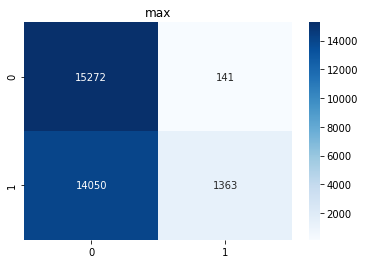

{'accuracy': 0.5396, 'f1': 0.1611, 'precision': 0.9062, 'recall': 0.0884, 'method': 'max'}


In [ ]:
plot_test_models(scores_forest_df_SC1, df_HS1, models_SC1, hs1_embs_dict)

## Random Forest SC3

In [ ]:
X = df_SC3.drop(columns = 'Interaction').to_numpy()
y = df_SC3['Interaction']

scores_forest_SC3 = []
models_SC3 = {}

for method in method_dict.keys():
    models_SC3[method] = RandomForestClassifier(max_depth=12, max_features='log2', min_samples_split=10, n_estimators=200, random_state=0)
    scores_forest_SC3.append(train_test_model(X, y, models_SC3[method], 10, sc3_embs_dict, method, method))

In [ ]:
scores_forest_df_SC3 = pd.DataFrame(scores_forest_SC3)
scores_forest_df_SC3.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
4,0.8291,0.9302,0.8193,0.8687,0.7751,max
5,0.8291,0.9316,0.8158,0.8840,0.7574,min
0,0.8267,0.9469,0.8174,0.8632,0.7763,hadamard
3,0.8208,0.9732,0.8154,0.8405,0.7917,concatenation
1,0.8072,0.9071,0.7910,0.8629,0.7302,mean
2,0.8072,0.9074,0.7910,0.8629,0.7302,addition


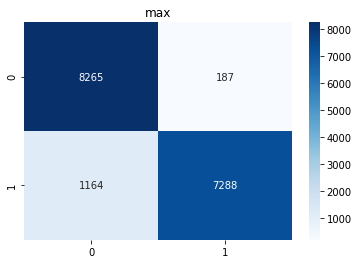

{'accuracy': 0.9201, 'f1': 0.9152, 'precision': 0.975, 'recall': 0.8623, 'method': 'max'}


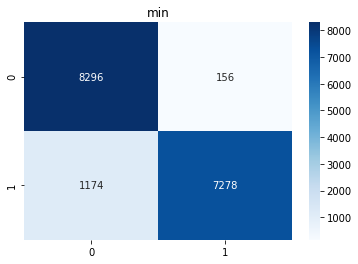

{'accuracy': 0.9213, 'f1': 0.9163, 'precision': 0.979, 'recall': 0.8611, 'method': 'min'}


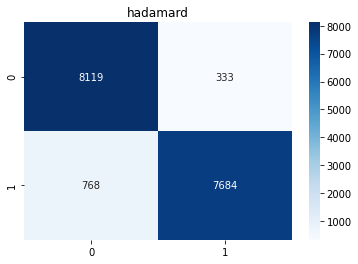

{'accuracy': 0.9349, 'f1': 0.9331, 'precision': 0.9585, 'recall': 0.9091, 'method': 'hadamard'}


In [ ]:
plot_test_models(scores_forest_df_SC3, df_SC3, models_SC3, sc3_embs_dict)

### Testing on other species

Testing DM

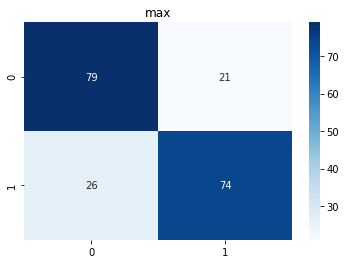

{'accuracy': 0.765, 'f1': 0.759, 'precision': 0.7789, 'recall': 0.74, 'method': 'max'}


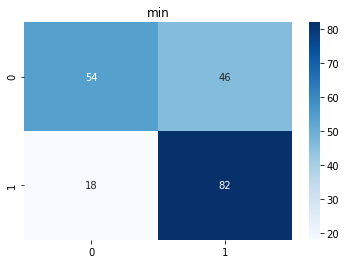

{'accuracy': 0.68, 'f1': 0.7193, 'precision': 0.6406, 'recall': 0.82, 'method': 'min'}


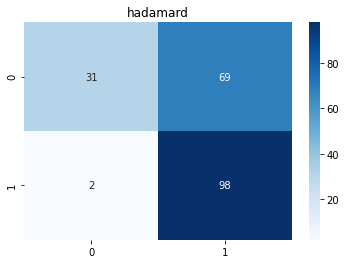

{'accuracy': 0.645, 'f1': 0.7341, 'precision': 0.5868, 'recall': 0.98, 'method': 'hadamard'}


In [ ]:
plot_test_models(scores_forest_df_SC3,df_DM3, models_SC3, dm3_embs_dict)

Testing EC

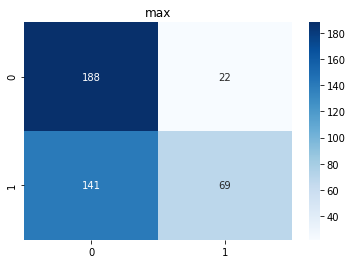

{'accuracy': 0.6119, 'f1': 0.4585, 'precision': 0.7582, 'recall': 0.3286, 'method': 'max'}


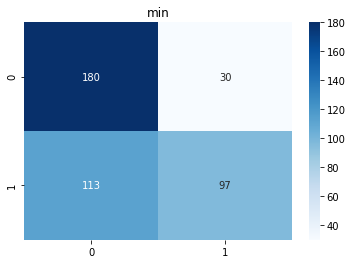

{'accuracy': 0.6595, 'f1': 0.5757, 'precision': 0.7638, 'recall': 0.4619, 'method': 'min'}


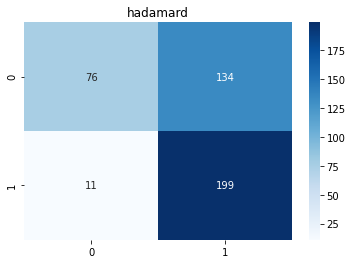

{'accuracy': 0.6548, 'f1': 0.733, 'precision': 0.5976, 'recall': 0.9476, 'method': 'hadamard'}


In [ ]:
plot_test_models(scores_forest_df_SC3, df_EC3, models_SC3, ec3_embs_dict)

Testing HS

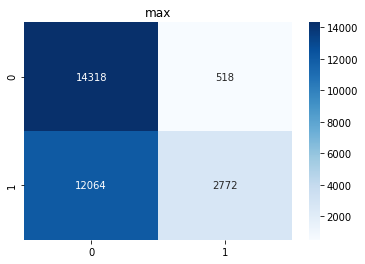

{'accuracy': 0.576, 'f1': 0.3059, 'precision': 0.8426, 'recall': 0.1868, 'method': 'max'}


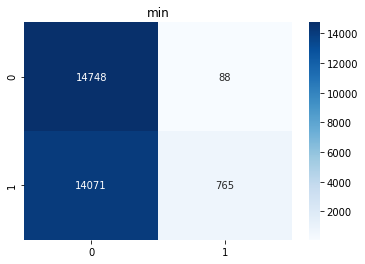

{'accuracy': 0.5228, 'f1': 0.0975, 'precision': 0.8968, 'recall': 0.0516, 'method': 'min'}


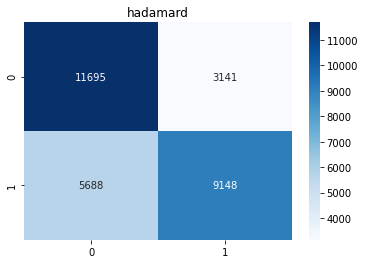

{'accuracy': 0.7024, 'f1': 0.6745, 'precision': 0.7444, 'recall': 0.6166, 'method': 'hadamard'}


In [ ]:
plot_test_models(scores_forest_df_SC3, df_HS3, models_SC3, hs3_embs_dict)

## Multi-layer Perceptron classifier


In [ ]:
scores_mlp_SC1 = []
models_SC1_mlp = {}

for method in method_dict.keys():
    models_SC1_mlp[method] = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
    scores_mlp_SC1.append(train_test_model(X, y, models_SC1_mlp[method], 10, sc1_embs_dict, method, method))

In [ ]:
scores_mlp_df_SC1 = pd.DataFrame(scores_mlp_SC1)
scores_mlp_df_SC1.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.5115,0.9990,0.5095,0.5113,0.5077,hadamard
3,0.5092,0.9963,0.5030,0.5091,0.4970,concatenation
4,0.5044,0.9927,0.5012,0.5042,0.4982,max
2,0.5033,0.9860,0.4884,0.5031,0.4746,addition
5,0.5003,0.9943,0.4761,0.5000,0.4544,min
1,0.4867,0.9743,0.4864,0.4864,0.4864,mean


## Support Vector Machines

In [ ]:
scores_svc_SC1 = []
models_SC1_svc = {}

for method in method_dict.keys():
    models_SC1_svc[method] = SVC()
    scores_svc_SC1.append(train_test_model(X, y, models_SC1_svc[method], 10, sc1_embs_dict, method, method))

In [ ]:
scores_svc_df_SC1 = pd.DataFrame(scores_svc_SC1)
scores_svc_df_SC1.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.60,0.8833,0.5556,0.6250,0.5,hadamard
4,0.55,0.8111,0.5714,0.5455,0.6,max
1,0.45,0.7833,0.4762,0.4545,0.5,mean
2,0.45,0.7833,0.4762,0.4545,0.5,addition
3,0.45,0.8389,0.4762,0.4545,0.5,concatenation
5,0.40,0.8278,0.4000,0.4000,0.4,min


# Training with two species

## Training with *Drosophila melanogaster* and *Escherichia coli*

In [ ]:
X = df_EC1.drop(columns=['Interaction'])

y = df_EC1['Interaction']

scores_forest_DM1EC1 = []
models_DM1EC1 = {}

for method in method_dict.keys():
    models_DM1EC1[method] = RandomForestClassifier(max_depth=4, max_features='log2', min_samples_split=10, n_estimators=100, random_state=0)
    train_test_model(X, y, models_DM1EC1[method], 10, ec1_embs_dict, method, method)

In [ ]:
X = df_DM1.drop(columns=['Interaction'])

y = df_DM1['Interaction']

for method in method_dict.keys():
    models_DM1EC1[method] = RandomForestClassifier(max_depth=4, max_features='log2', min_samples_split=10, n_estimators=100, random_state=0)
    scores_forest_DM1EC1.append(train_test_model(X, y, models_DM1EC1[method], 10, dm1_embs_dict, method, method))

In [ ]:
scores_forest_df_DM1EC1 = pd.DataFrame(scores_forest_DM1EC1)
scores_forest_df_DM1EC1.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.9730,0.9817,0.9744,0.9500,1.0000,hadamard
4,0.9730,0.9664,0.9744,0.9500,1.0000,max
5,0.9189,0.9694,0.9268,0.8636,1.0000,min
1,0.8919,0.9450,0.8947,0.8947,0.8947,mean
2,0.8919,0.9450,0.8947,0.8947,0.8947,addition
3,0.8649,0.9450,0.8718,0.8500,0.8947,concatenation


In [ ]:
df_DM1EC1 = pd.concat([df_EC1, df_DM1])

new_dict = {}

for key in dm1_embs_dict.keys():
    new_key= key + len(ec1_embs_dict)
    new_dict[new_key] = dm1_embs_dict[key]

dm1ec1_embs_dict = {**ec1_embs_dict, **new_dict}

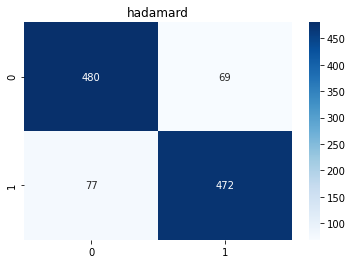

{'accuracy': 0.867, 'f1': 0.8661, 'precision': 0.8725, 'recall': 0.8597, 'method': 'hadamard'}


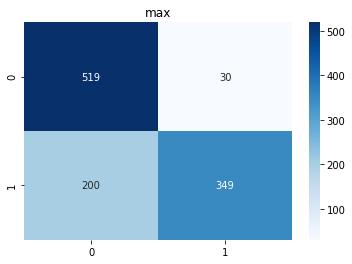

{'accuracy': 0.7905, 'f1': 0.7522, 'precision': 0.9208, 'recall': 0.6357, 'method': 'max'}


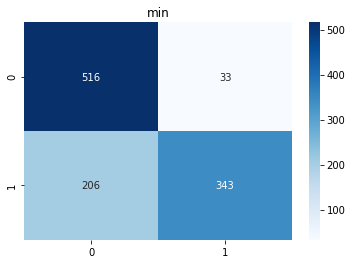

{'accuracy': 0.7823, 'f1': 0.7416, 'precision': 0.9122, 'recall': 0.6248, 'method': 'min'}


In [ ]:
plot_test_models(scores_forest_df_DM1EC1, df_DM1EC1, models_DM1EC1, dm1ec1_embs_dict)

### Testing on other species

*Homo sapiens*

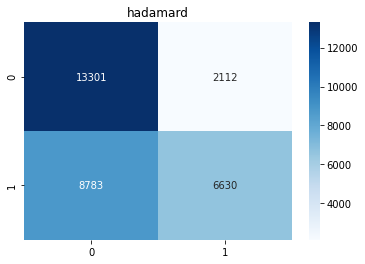

{'accuracy': 0.6466, 'f1': 0.549, 'precision': 0.7584, 'recall': 0.4302, 'method': 'hadamard'}


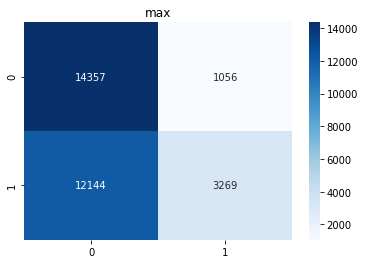

{'accuracy': 0.5718, 'f1': 0.3312, 'precision': 0.7558, 'recall': 0.2121, 'method': 'max'}


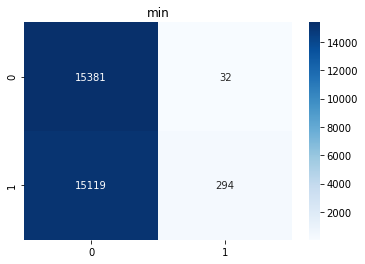

{'accuracy': 0.5085, 'f1': 0.0374, 'precision': 0.9018, 'recall': 0.0191, 'method': 'min'}


In [ ]:
plot_test_models(scores_forest_df_DM1EC1, df_HS1, models_DM1EC1, hs1_embs_dict)



*Saccharomyces cerevisiae*

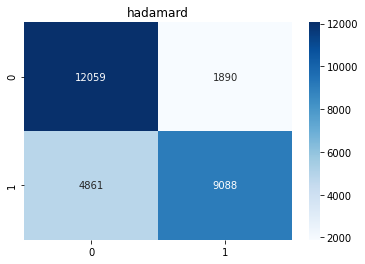

{'accuracy': 0.758, 'f1': 0.7292, 'precision': 0.8278, 'recall': 0.6515, 'method': 'hadamard'}


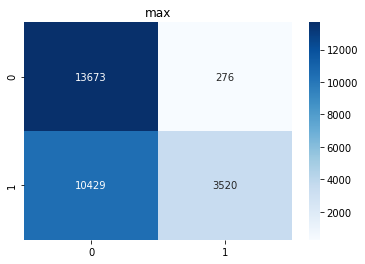

{'accuracy': 0.6163, 'f1': 0.3967, 'precision': 0.9273, 'recall': 0.2523, 'method': 'max'}


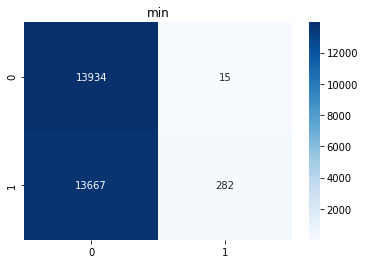

{'accuracy': 0.5096, 'f1': 0.0396, 'precision': 0.9495, 'recall': 0.0202, 'method': 'min'}


In [ ]:
plot_test_models(scores_forest_df_DM1EC1, df_SC1, models_DM1EC1, sc1_embs_dict)

## Training with *Drosophila melanogaster* and *Homo sapiens*

In [ ]:
X = df_HS1.drop(columns=['Interaction'])

y = df_HS1['Interaction']

scores_forest_DM1HS1 = []
models_DM1HS1 = {}

for method in method_dict.keys():
    models_DM1HS1[method] = RandomForestClassifier(max_depth=4, max_features='log2', min_samples_split=10, n_estimators=100, random_state=0)
    train_test_model(X, y, models_DM1HS1[method], 10, hs1_embs_dict, method, method)

In [ ]:
X = df_DM1.drop(columns=['Interaction'])

y = df_DM1['Interaction']

for method in method_dict.keys():
    models_DM1EC1[method] = RandomForestClassifier(max_depth=4, max_features='log2', min_samples_split=10, n_estimators=100, random_state=0)
    scores_forest_DM1HS1.append(train_test_model(X, y, models_DM1HS1[method], 10, dm1_embs_dict, method, method))

In [ ]:
scores_forest_df_DM1HS1 = pd.DataFrame(scores_forest_DM1HS1)
scores_forest_df_DM1HS1.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.9730,0.9817,0.9744,0.9500,1.0000,hadamard
4,0.9730,0.9664,0.9744,0.9500,1.0000,max
5,0.9189,0.9694,0.9268,0.8636,1.0000,min
1,0.8919,0.9450,0.8947,0.8947,0.8947,mean
2,0.8919,0.9450,0.8947,0.8947,0.8947,addition
3,0.8649,0.9450,0.8718,0.8500,0.8947,concatenation


In [ ]:
df_DM1HS1 = pd.concat([df_HS1, df_DM1])

new_dict = {}

for key in dm1_embs_dict.keys():
    new_key= key + len(hs1_embs_dict)
    new_dict[new_key] = dm1_embs_dict[key]

dm1hs1_embs_dict = {**hs1_embs_dict, **new_dict}

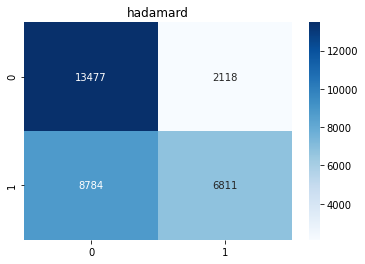

{'accuracy': 0.6505, 'f1': 0.5555, 'precision': 0.7628, 'recall': 0.4367, 'method': 'hadamard'}


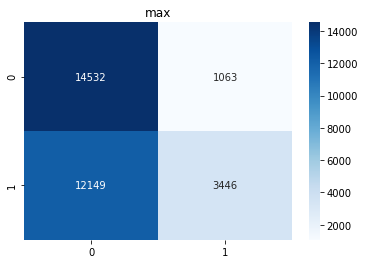

{'accuracy': 0.5764, 'f1': 0.3428, 'precision': 0.7642, 'recall': 0.221, 'method': 'max'}


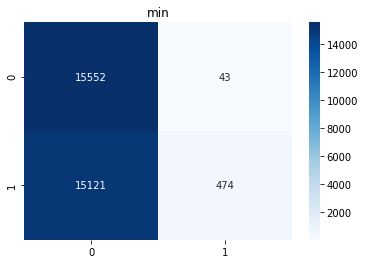

{'accuracy': 0.5138, 'f1': 0.0588, 'precision': 0.9168, 'recall': 0.0304, 'method': 'min'}


In [ ]:
plot_test_models(scores_forest_df_DM1HS1, df_DM1HS1, models_DM1HS1, dm1hs1_embs_dict)

### Testing on other species

*Saccharomyces cerevisiae*

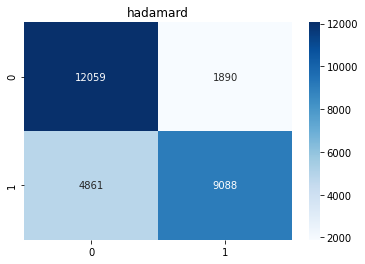

{'accuracy': 0.758, 'f1': 0.7292, 'precision': 0.8278, 'recall': 0.6515, 'method': 'hadamard'}


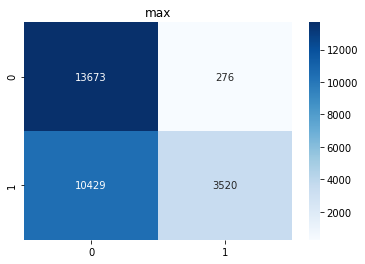

{'accuracy': 0.6163, 'f1': 0.3967, 'precision': 0.9273, 'recall': 0.2523, 'method': 'max'}


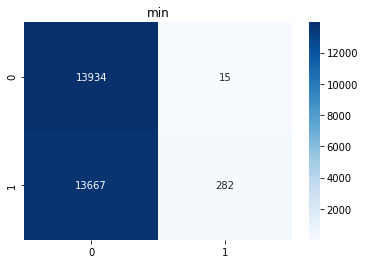

{'accuracy': 0.5096, 'f1': 0.0396, 'precision': 0.9495, 'recall': 0.0202, 'method': 'min'}


In [ ]:
plot_test_models(scores_forest_df_DM1HS1, df_SC1, models_DM1HS1, sc1_embs_dict)

*Escherichia coli*

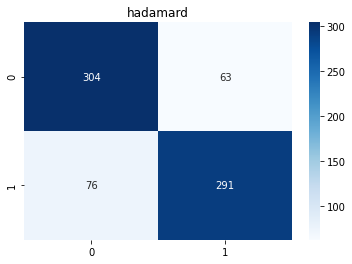

{'accuracy': 0.8106, 'f1': 0.8072, 'precision': 0.822, 'recall': 0.7929, 'method': 'hadamard'}


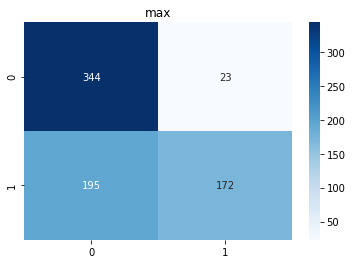

{'accuracy': 0.703, 'f1': 0.6121, 'precision': 0.8821, 'recall': 0.4687, 'method': 'max'}


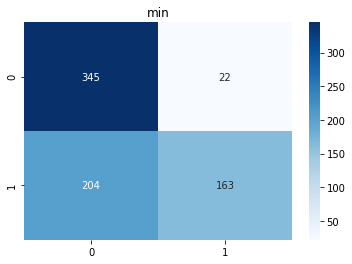

{'accuracy': 0.6921, 'f1': 0.5906, 'precision': 0.8811, 'recall': 0.4441, 'method': 'min'}


In [ ]:
plot_test_models(scores_forest_df_DM1HS1, df_EC1, models_DM1HS1, ec1_embs_dict)

## Training with *Drosophila melanogaster* and *Saccharomyces cerevisiae*

In [ ]:
X = df_DM1.drop(columns=['Interaction'])

y = df_DM1['Interaction']

scores_forest_DM1SC1 = []
models_DM1SC1 = {}

for method in method_dict.keys():
    models_DM1SC1[method] = RandomForestClassifier(max_depth=4, max_features='log2', min_samples_split=10, n_estimators=100, random_state=0)
    train_test_model(X, y, models_DM1SC1[method], 10, dm1_embs_dict, method, method)

In [ ]:
X = df_SC1.drop(columns=['Interaction'])

y = df_SC1['Interaction']

for method in method_dict.keys():
    models_DM1SC1[method] = RandomForestClassifier(max_depth=4, max_features='log2', min_samples_split=10, n_estimators=100, random_state=0)
    scores_forest_DM1SC1.append(train_test_model(X, y, models_DM1SC1[method], 10, sc1_embs_dict, method, method))

In [ ]:
scores_forest_df_DM1SC1 = pd.DataFrame(scores_forest_DM1SC1)
scores_forest_df_DM1SC1.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.8100,0.8184,0.7928,0.8719,0.7269,hadamard
5,0.7516,0.7625,0.7159,0.8362,0.6258,min
4,0.7480,0.7651,0.7166,0.8186,0.6373,max
1,0.7057,0.7221,0.6552,0.7911,0.5591,mean
2,0.7057,0.7221,0.6552,0.7911,0.5591,addition
3,0.6978,0.7193,0.6632,0.7491,0.5950,concatenation


In [ ]:
df_DM1SC1 = pd.concat([df_DM1, df_SC1])

new_dict = {}

for key in dm1_embs_dict.keys():
    new_key= key + len(sc1_embs_dict)
    new_dict[new_key] = dm1_embs_dict[key]

dm1sc1_embs_dict = {**sc1_embs_dict, **new_dict}

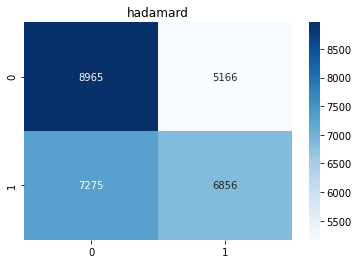

{'accuracy': 0.5598, 'f1': 0.5243, 'precision': 0.5703, 'recall': 0.4852, 'method': 'hadamard'}


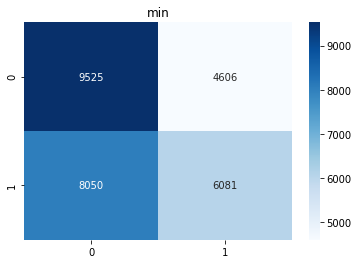

{'accuracy': 0.5522, 'f1': 0.49, 'precision': 0.569, 'recall': 0.4303, 'method': 'min'}


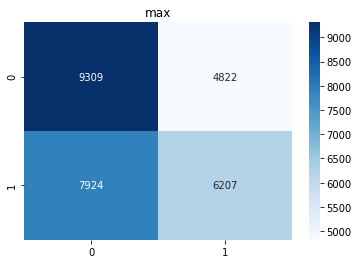

{'accuracy': 0.549, 'f1': 0.4934, 'precision': 0.5628, 'recall': 0.4392, 'method': 'max'}


In [ ]:
plot_test_models(scores_forest_df_DM1SC1, df_DM1SC1, models_DM1SC1, dm1sc1_embs_dict)

### Testing on other species

*Homo sapiens*

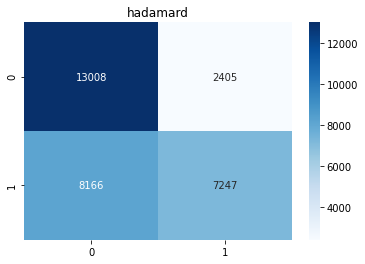

{'accuracy': 0.6571, 'f1': 0.5783, 'precision': 0.7508, 'recall': 0.4702, 'method': 'hadamard'}


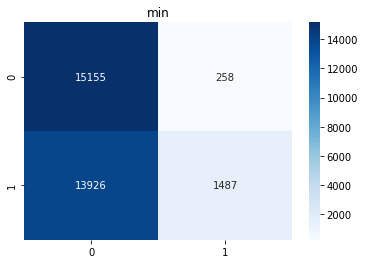

{'accuracy': 0.5399, 'f1': 0.1733, 'precision': 0.8521, 'recall': 0.0965, 'method': 'min'}


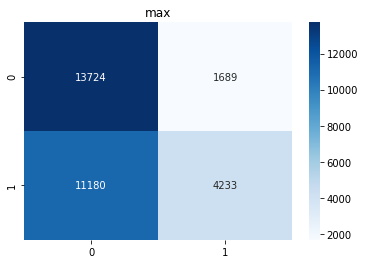

{'accuracy': 0.5825, 'f1': 0.3968, 'precision': 0.7148, 'recall': 0.2746, 'method': 'max'}


In [ ]:
plot_test_models(scores_forest_df_DM1SC1, df_HS1, models_DM1SC1, hs1_embs_dict)

*Escherichia coli*

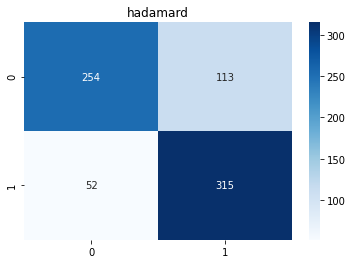

{'accuracy': 0.7752, 'f1': 0.7925, 'precision': 0.736, 'recall': 0.8583, 'method': 'hadamard'}


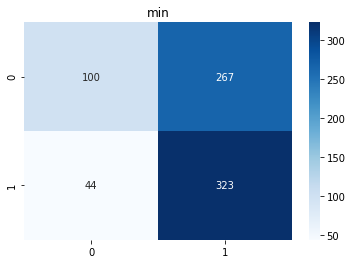

{'accuracy': 0.5763, 'f1': 0.675, 'precision': 0.5475, 'recall': 0.8801, 'method': 'min'}


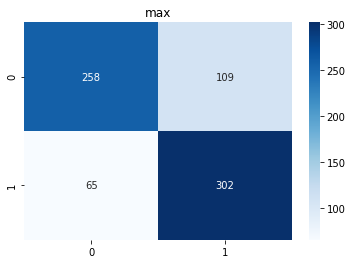

{'accuracy': 0.7629, 'f1': 0.7763, 'precision': 0.7348, 'recall': 0.8229, 'method': 'max'}


In [ ]:
plot_test_models(scores_forest_df_DM1SC1, df_EC1, models_DM1SC1, ec1_embs_dict)

## Training with *Escherichia coli* and *Homo sapiens*

In [ ]:
X = df_EC1.drop(columns=['Interaction'])

y = df_EC1['Interaction']

scores_forest_EC1HS1 = []
models_EC1HS1 = {}

for method in method_dict.keys():
    models_EC1HS1[method] = RandomForestClassifier(max_depth=4, max_features='log2', min_samples_split=10, n_estimators=100, random_state=0)
    train_test_model(X, y, models_EC1HS1[method], 10, ec1_embs_dict, method, method)

In [ ]:
X = df_HS1.drop(columns=['Interaction'])

y = df_HS1['Interaction']

for method in method_dict.keys():
    models_EC1HS1[method] = RandomForestClassifier(max_depth=4, max_features='log2', min_samples_split=10, n_estimators=100, random_state=0)
    scores_forest_EC1HS1.append(train_test_model(X, y, models_EC1HS1[method], 10, hs1_embs_dict, method, method))

In [ ]:
scores_forest_df_EC1HS1 = pd.DataFrame(scores_forest_EC1HS1)
scores_forest_df_EC1HS1.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.7230,0.7306,0.7265,0.7173,0.7359,hadamard
5,0.6883,0.6961,0.6761,0.7034,0.6509,min
4,0.6799,0.6921,0.6616,0.7013,0.6262,max
1,0.6523,0.6681,0.6296,0.6733,0.5912,mean
2,0.6523,0.6681,0.6296,0.6733,0.5912,addition
3,0.6286,0.6533,0.6338,0.6248,0.6431,concatenation


In [ ]:
df_EC1HS1 = pd.concat([df_EC1, df_HS1])

new_dict = {}

for key in ec1_embs_dict.keys():
    new_key= key + len(hs1_embs_dict)
    new_dict[new_key] = ec1_embs_dict[key]

ec1hs1_embs_dict = {**hs1_embs_dict, **new_dict}

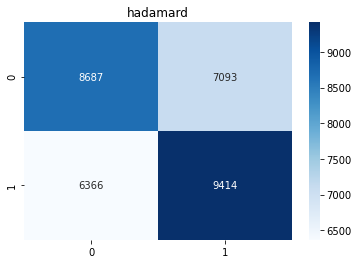

{'accuracy': 0.5735, 'f1': 0.5831, 'precision': 0.5703, 'recall': 0.5966, 'method': 'hadamard'}


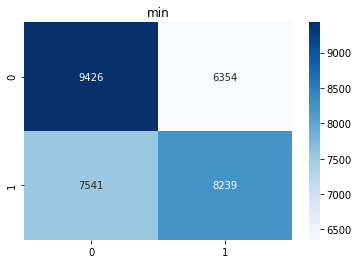

{'accuracy': 0.5597, 'f1': 0.5425, 'precision': 0.5646, 'recall': 0.5221, 'method': 'min'}


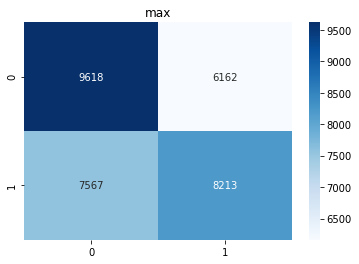

{'accuracy': 0.565, 'f1': 0.5447, 'precision': 0.5713, 'recall': 0.5205, 'method': 'max'}


In [ ]:
plot_test_models(scores_forest_df_EC1HS1, df_EC1HS1, models_EC1HS1, ec1hs1_embs_dict)

### Testing on other species

*Drosophila melanogaster*

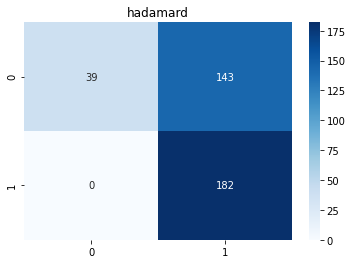

{'accuracy': 0.6071, 'f1': 0.7179, 'precision': 0.56, 'recall': 1.0, 'method': 'hadamard'}


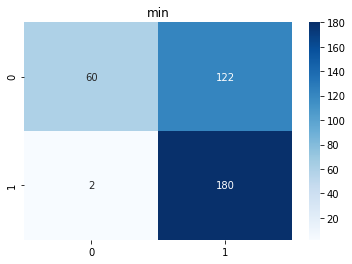

{'accuracy': 0.6593, 'f1': 0.7438, 'precision': 0.596, 'recall': 0.989, 'method': 'min'}


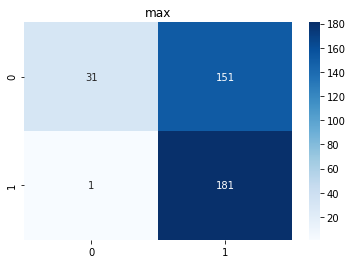

{'accuracy': 0.5824, 'f1': 0.7043, 'precision': 0.5452, 'recall': 0.9945, 'method': 'max'}


In [ ]:
plot_test_models(scores_forest_df_EC1HS1, df_DM1, models_EC1HS1, dm1_embs_dict)

*Saccharomyces cerevisae* 

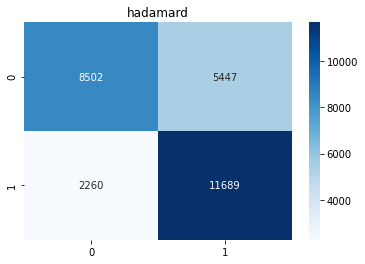

{'accuracy': 0.7237, 'f1': 0.7521, 'precision': 0.6821, 'recall': 0.838, 'method': 'hadamard'}


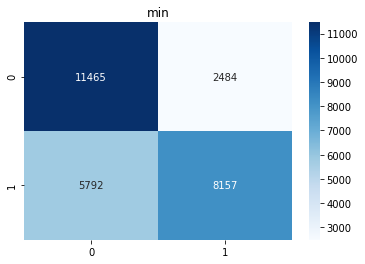

{'accuracy': 0.7033, 'f1': 0.6634, 'precision': 0.7666, 'recall': 0.5848, 'method': 'min'}


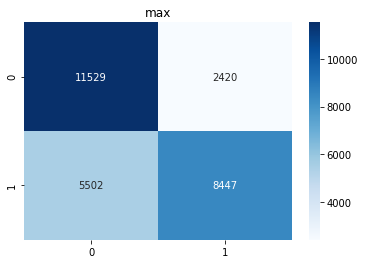

{'accuracy': 0.716, 'f1': 0.6808, 'precision': 0.7773, 'recall': 0.6056, 'method': 'max'}


In [ ]:
plot_test_models(scores_forest_df_EC1HS1, df_SC1, models_EC1HS1, sc1_embs_dict)

## Training with *Escherichia coli* and *Saccharomyces cerevisiae*

In [ ]:
X = df_EC1.drop(columns=['Interaction'])

y = df_EC1['Interaction']

scores_forest_EC1SC1 = []
models_EC1SC1 = {}

for method in method_dict.keys():
    models_EC1SC1[method] = RandomForestClassifier(max_depth=4, max_features='log2', min_samples_split=10, n_estimators=100, random_state=0)
    train_test_model(X, y, models_EC1SC1[method], 10, ec1_embs_dict, method, method)

In [ ]:
X = df_SC1.drop(columns=['Interaction'])

y = df_SC1['Interaction']

for method in method_dict.keys():
    models_EC1SC1[method] = RandomForestClassifier(max_depth=4, max_features='log2', min_samples_split=10, n_estimators=100, random_state=0)
    scores_forest_EC1SC1.append(train_test_model(X, y, models_EC1SC1[method], 10, sc1_embs_dict, method, method))

In [ ]:
scores_forest_df_EC1SC1 = pd.DataFrame(scores_forest_EC1SC1)
scores_forest_df_EC1SC1.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.8100,0.8184,0.7928,0.8719,0.7269,hadamard
5,0.7516,0.7625,0.7159,0.8362,0.6258,min
4,0.7480,0.7651,0.7166,0.8186,0.6373,max
1,0.7057,0.7221,0.6552,0.7911,0.5591,mean
2,0.7057,0.7221,0.6552,0.7911,0.5591,addition
3,0.6978,0.7193,0.6632,0.7491,0.5950,concatenation


In [ ]:
df_EC1SC1 = pd.concat([df_EC1, df_SC1])

new_dict = {}

for key in ec1_embs_dict.keys():
    new_key= key + len(sc1_embs_dict)
    new_dict[new_key] = ec1_embs_dict[key]

ec1sc1_embs_dict = {**sc1_embs_dict, **new_dict}

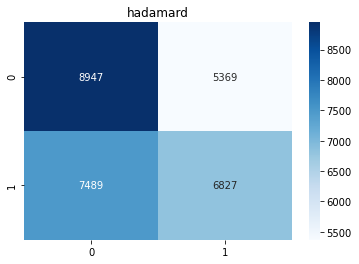

{'accuracy': 0.5509, 'f1': 0.515, 'precision': 0.5598, 'recall': 0.4769, 'method': 'hadamard'}


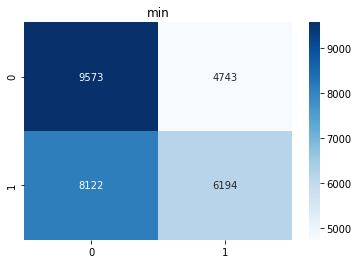

{'accuracy': 0.5507, 'f1': 0.4906, 'precision': 0.5663, 'recall': 0.4327, 'method': 'min'}


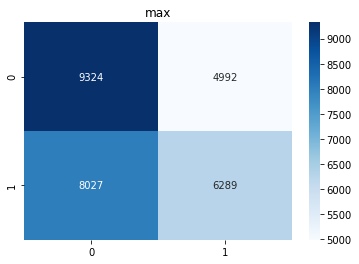

{'accuracy': 0.5453, 'f1': 0.4914, 'precision': 0.5575, 'recall': 0.4393, 'method': 'max'}


In [ ]:
plot_test_models(scores_forest_df_EC1SC1, df_EC1SC1, models_EC1SC1, ec1sc1_embs_dict)

### Testing on other species

*Drosophila melanogaster*

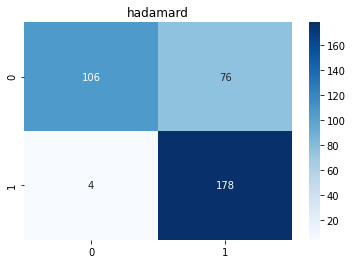

{'accuracy': 0.7802, 'f1': 0.8165, 'precision': 0.7008, 'recall': 0.978, 'method': 'hadamard'}


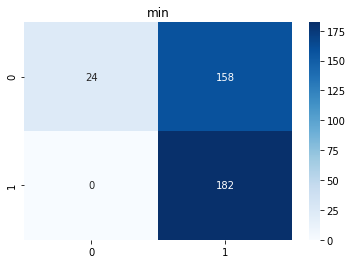

{'accuracy': 0.5659, 'f1': 0.6973, 'precision': 0.5353, 'recall': 1.0, 'method': 'min'}


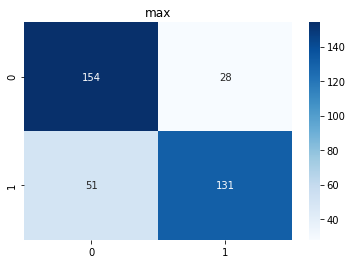

{'accuracy': 0.783, 'f1': 0.7683, 'precision': 0.8239, 'recall': 0.7198, 'method': 'max'}


In [ ]:
plot_test_models(scores_forest_df_EC1SC1, df_DM1, models_EC1SC1, dm1_embs_dict)

*Homo sapiens*

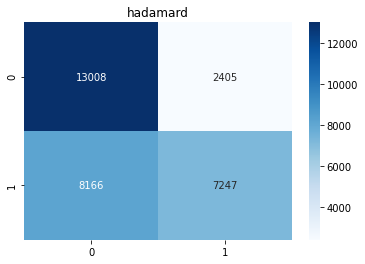

{'accuracy': 0.6571, 'f1': 0.5783, 'precision': 0.7508, 'recall': 0.4702, 'method': 'hadamard'}


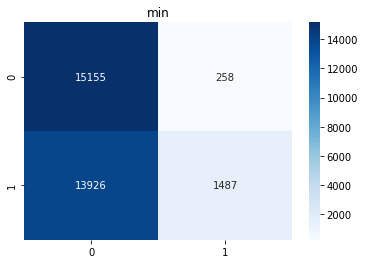

{'accuracy': 0.5399, 'f1': 0.1733, 'precision': 0.8521, 'recall': 0.0965, 'method': 'min'}


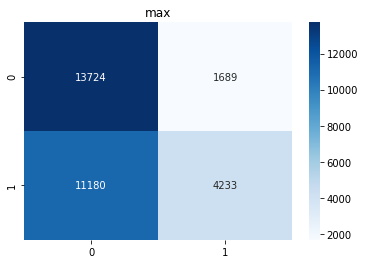

{'accuracy': 0.5825, 'f1': 0.3968, 'precision': 0.7148, 'recall': 0.2746, 'method': 'max'}


In [ ]:
plot_test_models(scores_forest_df_EC1SC1, df_HS1, models_EC1SC1, hs1_embs_dict)

## Training with *Homo sapiens* and *Saccharomyces cerevisiae*

In [ ]:
X = df_HS1.drop(columns=['Interaction'])

y = df_HS1['Interaction']

scores_forest_HS1SC1 = []
models_HS1SC1 = {}

for method in method_dict.keys():
    models_HS1SC1[method] = RandomForestClassifier(max_depth=4, max_features='log2', min_samples_split=10, n_estimators=100, random_state=0)
    train_test_model(X, y, models_HS1SC1[method], 10, hs1_embs_dict, method, method)

In [ ]:
X = df_SC1.drop(columns=['Interaction'])

y = df_SC1['Interaction']

for method in method_dict.keys():
    models_HS1SC1[method] = RandomForestClassifier(max_depth=4, max_features='log2', min_samples_split=10, n_estimators=100, random_state=0)
    scores_forest_HS1SC1.append(train_test_model(X, y, models_HS1SC1[method], 10, sc1_embs_dict, method, method))

In [ ]:
scores_forest_df_HS1SC1 = pd.DataFrame(scores_forest_HS1SC1)
scores_forest_df_HS1SC1.sort_values(['accuracy_test'], ascending=False)

,accuracy_test,accuracy_train,f1s,precision,recall,label
0,0.8100,0.8184,0.7928,0.8719,0.7269,hadamard
5,0.7516,0.7625,0.7159,0.8362,0.6258,min
4,0.7480,0.7651,0.7166,0.8186,0.6373,max
1,0.7057,0.7221,0.6552,0.7911,0.5591,mean
2,0.7057,0.7221,0.6552,0.7911,0.5591,addition
3,0.6978,0.7193,0.6632,0.7491,0.5950,concatenation


In [ ]:
df_HS1SC1 = pd.concat([df_HS1, df_SC1])

new_dict = {}

for key in hs1_embs_dict.keys():
    new_key= key + len(sc1_embs_dict)
    new_dict[new_key] = hs1_embs_dict[key]

hs1sc1_embs_dict = {**sc1_embs_dict, **new_dict}

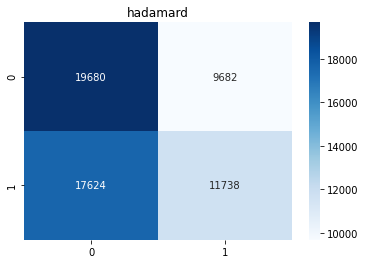

{'accuracy': 0.535, 'f1': 0.4623, 'precision': 0.548, 'recall': 0.3998, 'method': 'hadamard'}


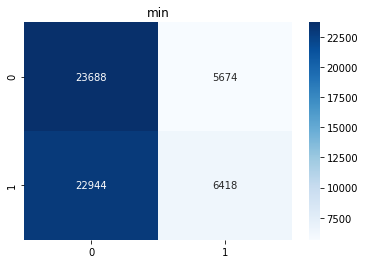

{'accuracy': 0.5127, 'f1': 0.3096, 'precision': 0.5308, 'recall': 0.2186, 'method': 'min'}


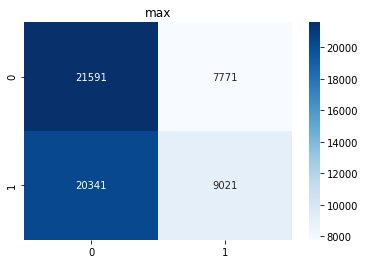

{'accuracy': 0.5213, 'f1': 0.3909, 'precision': 0.5372, 'recall': 0.3072, 'method': 'max'}


In [ ]:
plot_test_models(scores_forest_df_HS1SC1, df_HS1SC1, models_HS1SC1, hs1sc1_embs_dict)

### Testing on other species

*Drosophila melanogaster*

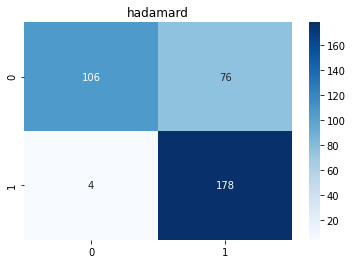

{'accuracy': 0.7802, 'f1': 0.8165, 'precision': 0.7008, 'recall': 0.978, 'method': 'hadamard'}


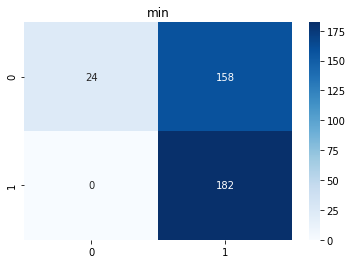

{'accuracy': 0.5659, 'f1': 0.6973, 'precision': 0.5353, 'recall': 1.0, 'method': 'min'}


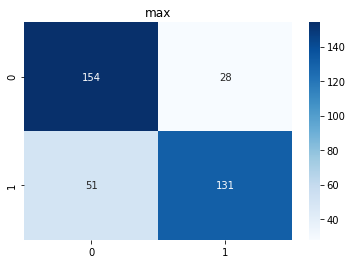

{'accuracy': 0.783, 'f1': 0.7683, 'precision': 0.8239, 'recall': 0.7198, 'method': 'max'}


In [ ]:
plot_test_models(scores_forest_df_HS1SC1, df_DM1, models_HS1SC1, dm1_embs_dict)

*Escherichia coli*

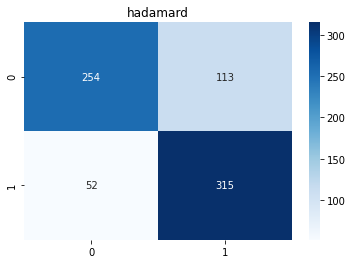

{'accuracy': 0.7752, 'f1': 0.7925, 'precision': 0.736, 'recall': 0.8583, 'method': 'hadamard'}


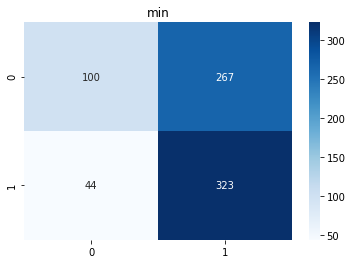

{'accuracy': 0.5763, 'f1': 0.675, 'precision': 0.5475, 'recall': 0.8801, 'method': 'min'}


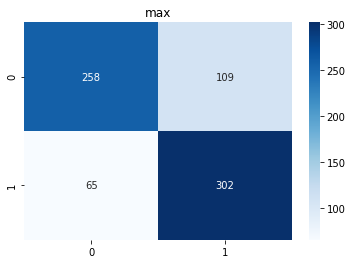

{'accuracy': 0.7629, 'f1': 0.7763, 'precision': 0.7348, 'recall': 0.8229, 'method': 'max'}


In [ ]:
plot_test_models(scores_forest_df_HS1SC1, df_EC1, models_HS1SC1, ec1_embs_dict)